## Applying K25 to Lee

<u>Data</u>

Dropsondes around 09-08 at 2300 UTC.

We have a SAR acquisition at 2200 UTC, however it is contaminated by rain at Rmax.

Alternatively we may consider the SAR image on 09-08 at 0925 UTC or the one on 09-09 at 0950 UTC.

<u>Tests</u>

Rq/TODO: Si j'essaie de fitter la phase manuellement j'ai un problème dans ma formule (pour l'instant); A regler ? 

Idée déjà testée à plus explorer: tweaker le modele pour qu'il capture l'asymétrie observée. Ca vient du fait que j'ai négligé Ut, mais aussi u du/dr alors qu'il est significatif proche de la surface proche de Rmax (w dM/dz a aussi été négligé à tord puisqu'il est significatif dans l'eyewall); J'ai testé deux choses: 1) Je peux changer le vent gradient en lui imposant 2 * Rmax pour le rendre plus réaliste, mais le pb c'est que le vent de surface devient alors incohérent avec le SAR. En faisant ça la pente outer-core de l'asymétrie est bien matchée mais le max d'asymétrie Kepert est quand même très proche de Rmax, ce qui fait que l'asymétrie est largement surestimée dans le near-core. Pour montrer qu'on s'attend bien à un vent gradient qui a 2 * Rmax, possible de le calculer avec l'équilibre du vent gradient à partir des pressions des dropsondes (cf. Montgomery et al., 2014, QJRMS). 2) Je peux retarder le V dans les coefficients d'asymétrie de Rmax (i.e en prenant V(r - 1 * Rmax), possible d'ajuster le coeff devant Rmax en fonction des directions relatives entre storm motion et wind shear), cela marche un peu et me permet de très bien matcher l'asymétrie dans le near-core. Comment justifier cela dans le modèle? L'asymétrie est largement sous-estimée dans l'outer-core par contre. Si je combine les points 1 & 2, qui sont un peu empirriques, et que j'arrive à matcher l'asymétrie du SAR, vérifier que je matche l'inflow angle du diffusiomètre (en 2D, car l'inflow angle moyen devrait être bon dans tous les cas), et les dropsondes dans les différents thetas, auxquels cas ma méthode, certes semi-empirique, sera tout de même applicable à d'autres cas. La justification peut être empirique pour le point 2: on sait que la linéarisation n'est pas très juste dans le near-core, et qu'en plus V_gradient devrait avoir un Rmax légèrement plus grand que V_surface (cf IWRAP sur Larry), on peut justifier qu'empiriquement cela revient à appliquer les coefficients asymétriques avec V(r - 1 * Rmax).

Fitter avec la wind speed (et non avec l'asymétrie), et garder ces idées pour plus tard (alimentera la discussion du papier). Je peux aussi rajouter la vitesse de translation à l'extérieur du TC, çad dans la zone où V n'est plus >> Ut, en faisant un smoothing jusqu'à Rmax, pour augmenter mes asymétries artificiellement. En effet dans cette zone le modèle sous-estime l'asymétrie parce que Ut devrait être simplement sommé au champ de vent. Attention il y a du Vmin aussi qui prend déjà en compte la vitesse de translation, donc ajouter une fraction de Ut à la mano pour que ça matche les asymétries; Faire un smoothing linéaire jusqu'en Rmax.

Rq/TODO: Malheureusement quand je fitte conjointement avec le SAR et les DPs, le résultat du fit a du mal, car il dépend des valeurs initiales de K, C etc... (même si les solutions obtenues ne sont pas si différentes). Donc TODO: soit mieux fitter en normalisant mieux mes paramètres (pour qu'ils soient vraiment tous sur la même plage de valeurs), soit fitter en deux temps en s'assurant de matcher l'asymétrie du SAR puis en fittant la hauteur de la couche limite estimée à partir des DPs. Cela suggère que je regarde un peu comment Zhang calcule ses hauteurs de couche limite à partir des DPs (il y a en effet l'air d'y avoir peu de variabilité aux low-levels, et surtout peu de dropsondes à l'extérieur de l'eyewall, donc cela semble compliqué - peut-etre s'entrainer sur Larry car on a IWRAP et c'est assez clair). Idealement il faudrait faire les deux méthodes (fit et en ajustant avec les différentes features) et tomber sur le même résultat à chaque fois. Si je fitte avec les features je peux facilement le justifier en disant que les données ne sont pas inter-calibrées. Mais ça aurait été cool de pouvoir fitter sur les champs de vents comme ça je peux le faire sur des images cropées.

Rq: C, c1, et c2 gouvernent (normalement) le min et le max/phase de l'aymétrie de Cd... et donc de l'asymétrie du vent. Ce qui complique c'est que les valeurs de C, c1 et c2 vont dépendre du K que je suppose pour faire le fit. Mais je peux fitter sur le SAR pour 1 <= K <= 200, puis tester ces 200 champs de vents et voir lequel matche mieux les DPs.

Si je dois fitter d'abord sur le SAR puis sur le DPs: https://journals.ametsoc.org/view/journals/mwre/139/8/mwr-d-10-05017.1.xml ==> In terms of dynamics and/or kinematics, the height of the maximum wind speed (hvmax) can be used to define the boundary layer height (c'est leur hvmax). Ensuite: After testing different methods, such as taking the height where the radial wind velocity is either 0 or −2 m s−1 as the inflow layer top, we take the height where the radial velocity is 10% of the peak inflow as the inflow layer depth (hinfl). This definition gives consistent results when we composite the data by different hurricane intensity groups. Note that to estimate the inflow layer depth using the dropsonde data, the wind is first rotated into the radial and tangential wind components before compositing. Noter qu'ils font un composite, donc ça doit quand même être galère de le faire au cas par cas. Effectivement, sur Larry c'est déjà assez compliqué... Il va vraiment falloir attendre IWRAP je pense.

In [100]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
from scipy.optimize import minimize

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [101]:
# Paths & Params
PTHS = {
    'iwp_dir': '/home/arthur/data/tropical_cyclones/IWRAP/',
    'dsg_pth': '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sar_dir': '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/',
    'dps_dir': '/home/arthur/data/tropical_cyclones/dropsondes/NOAA_field_experiment/samples/al132023/20230908H1_NETCDF/'
    # 'sav_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/02_plotKepertAndSARasymmetries/',
}

In [102]:
# Open data
dsg = xr.open_dataset(PTHS['dsg_pth'])

# Open TC
# ds  = dsg.where(dsg.name == 'LEE', drop=True).sortby('time').isel(time=1) # 12 hours before
ds  = dsg.where(dsg.name == 'LEE', drop=True).sortby('time').isel(time=3) # Collocated SAR acquisition
# ds  = dsg.where(dsg.name == 'LEE', drop=True).sortby('time').isel(time=4) # 12 hours after
dsp = xr.open_dataset(PTHS['sar_dir'] + ds.file_tcva.item()).isel(time=0)

In [103]:
#########################
### General functions ###
#########################
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

#########################
### KEPERT 2025 MODEL ###
#########################
# Inertial stability
def I(Rs, Vs, fcor):
    dr   = np.diff(Rs[0, 0, :])[0] # meters
    ksi  = 2 * Vs / Rs + fcor
    zeta = np.gradient(Vs, dr, axis=2) + Vs / Rs + fcor
    return np.sqrt(ksi * zeta)

# Coefficients
def sqrt_alpha_beta(Rs, Vs, fcor):
    '''Corresponds to sqrt(alpha / beta).'''
    dr   = np.diff(Rs[0, 0, :])[0] # meters
    ksi  = 2 * Vs / Rs + fcor
    zeta = np.gradient(Vs, dr, axis=2) + Vs / Rs + fcor
    return np.sqrt(ksi / zeta)

def eta(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * ((Vs / Rs) + I(Rs, Vs, fcor))))

def ki(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * I(Rs, Vs, fcor)))

def psi(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * abs((Vs / Rs) - I(Rs, Vs, fcor))))

# Amplitudes
def A0(Rs, Vs, K, C, fcor):
    num = -ki(Rs, Vs, K, C, fcor) * Vs * [1 + 1j * (1 + ki(Rs, Vs, K, C, fcor))]
    den = 2 * ki(Rs, Vs, K, C, fcor) ** 2 + 3 * ki(Rs, Vs, K, C, fcor) + 2
    return num / den

def A1(Rs, Vs, K, C, c1, c2, fcor):
    '''Note the error of parenthesis in his Eq. 29 - I re-computed the exact coefficients, the parenthesis should be removed.'''
    # New notations
    ki0  = ki(Rs, Vs, K, C, fcor)
    ki1  = eta(Rs, Vs, K, C, fcor)
    ki_1 = psi(Rs, Vs, K, C, fcor)
    # New expressions
    num  = (c1 - 1j * c2) * ki1 * [(3 + 1j) * ki0 * ki_1 + (2 - 2j) * (ki0 + ki_1) - 4j] * abs(Vs)
    den  = 2 * (2 * ki0 ** 2 + 3 * ki0 + 2) * [(2 + 2j) * (1 + ki1 * ki_1) + 3 * ki1 + 3j * ki_1]
    return num / den

def A_1(Rs, Vs, K, C, c1, c2, fcor):
    '''Note the error of parenthesis in his Eq. 29 - I re-computed the exact coefficients, the parenthesis should be removed.'''
    # New notations
    ki0  = ki(Rs, Vs, K, C, fcor)
    ki1  = eta(Rs, Vs, K, C, fcor)
    ki_1 = psi(Rs, Vs, K, C, fcor)
    # New expressions
    num  = (c1 + 1j * c2) * ki_1 * [(3 + 1j) * ki0 * ki1 + (2 - 2j) * (ki0 + ki1) - 4j] * abs(Vs)
    den  = 2 * (2 * ki0 ** 2 + 3 * ki0 + 2) * [(2 + 2j) * (1 + ki1 * ki_1) + 3 * ki_1 + 3j * ki1]
    return num / den

def A1_prime(Rs, Vs, K, C, c1, c2, fcor):
    # New notations
    ki0  = ki(Rs, Vs, K, C, fcor)
    ki1  = eta(Rs, Vs, K, C, fcor)
    ki_1 = psi(Rs, Vs, K, C, fcor)
    # New expressions
    num  = (c1 - 1j * c2) * ki1 * [(1 - 3j) * ki0 * ki_1 + (2 - 2j) * ki0 - (2 + 2j) * ki_1 - 4j] * abs(Vs)
    den  = 2 * (2 * ki0 ** 2 + 3 * ki0 + 2) * [2 + 2j + 3 * (ki1 + ki_1) + (2 - 2j) * ki1 * ki_1]
    return num / den

def A_1_prime(Rs, Vs, K, C, c1, c2, fcor):
    # New notations
    ki0  = ki(Rs, Vs, K, C, fcor)
    ki1  = eta(Rs, Vs, K, C, fcor)
    ki_1 = psi(Rs, Vs, K, C, fcor)
    # New expressions
    num  = (c1 + 1j * c2) * ki_1 * [1j * (1 - 3j) * ki0 * ki1 + (2 - 2j) * ki0 + (2 + 2j) * ki1 - 4j] * abs(Vs)
    den  = 2 * (2 * ki0 ** 2 + 3 * ki0 + 2) * [2 - 2j + 3 * (ki1 + ki_1) + (2 + 2j) * ki1 * ki_1]
    return num / den

# Thicknesses
def delta0(Rs, Vs, K, fcor):
    return np.sqrt(2 * K / abs(I(Rs, Vs, fcor)))

def delta1(Rs, Vs, K, fcor):
    return np.sqrt(2 * K / abs(I(Rs, Vs, fcor) + Vs / Rs))

def delta_1(Rs, Vs, K, fcor):
    return np.sqrt(2 * K / abs(I(Rs, Vs, fcor) - Vs / Rs))

# Radial and tangential wind components
def u0(Rs, Vs, K, C, fcor, zi, z_ref):
    u0 = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A0(Rs, Vs, K, C, fcor) * np.exp(- (1 + 1j) * (zi - z_ref) / delta0(Rs, Vs, K, fcor)))
    return np.reshape(u0,  np.shape(u0)[1:])

def v0(Rs, Vs, K, C, fcor, zi, z_ref):
    v0 = np.imag(A0(Rs, Vs, K, C, fcor) * np.exp(- (1 + 1j) * (zi - z_ref) / delta0(Rs, Vs, K, fcor)))
    return np.reshape(v0,  np.shape(v0)[1:])

def u1(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h):
    u1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A1(Rs, Vs, K, C, c1, c2, fcor)       * np.exp(- (1 + 1j) * (zi - z_ref) / delta1(Rs, Vs, K, fcor) + 1j * h * THs))
    otherwise = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A1_prime(Rs, Vs, K, C, c1, c2, fcor) * np.exp(- (1 + 1j) * (zi - z_ref) / delta1(Rs, Vs, K, fcor) + 1j * h * THs))
    u1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    u1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return u1

def v1(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h):
    v1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = np.imag(A1(Rs, Vs, K, C, c1, c2, fcor)       * np.exp(- (1 + 1j) * (zi - z_ref) / delta1(Rs, Vs, K, fcor) + 1j * h * THs))
    otherwise = np.imag(A1_prime(Rs, Vs, K, C, c1, c2, fcor) * np.exp(- (1 + 1j) * (zi - z_ref) / delta1(Rs, Vs, K, fcor) + 1j * h * THs))
    v1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    v1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return v1

def u_1(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h):
    u1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A_1(Rs, Vs, K, C, c1, c2, fcor)       * np.exp(- (1 + 1j) * (zi - z_ref) / delta_1(Rs, Vs, K, fcor) - 1j * h * THs))
    otherwise = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A_1_prime(Rs, Vs, K, C, c1, c2, fcor) * np.exp(- (1 - 1j) * (zi - z_ref) / delta_1(Rs, Vs, K, fcor) - 1j * h * THs))
    u1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    u1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return u1

def v_1(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h):
    v1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = np.imag(A_1(Rs, Vs, K, C, c1, c2, fcor)       * np.exp(- (1 + 1j) * (zi - z_ref) / delta_1(Rs, Vs, K, fcor) - 1j * h * THs))
    otherwise = np.imag(A_1_prime(Rs, Vs, K, C, c1, c2, fcor) * np.exp(- (1 - 1j) * (zi - z_ref) / delta_1(Rs, Vs, K, fcor) - 1j * h * THs))
    v1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    v1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return v1

# TOTAL WIND COMPONENTS IN THE BL
def u_BL(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h):
    # print(np.shape(THs), np.shape(zi), np.shape(z_ref))
    # Vs_dyd = np.concatenate((np.stack([np.ones(np.argmax(Vs)) for i in range(np.shape(Vs)[0])]) * Vs[0, 0], Vs), axis=1)[:, :np.shape(Vs)[1]]
    # return u_1(THs, Rs, Vs_dyd, K, C, c1, c2, fcor, zi, z_ref, h) + u0(Rs, Vs, K, C, fcor, zi, z_ref) + u1(THs, Rs, Vs_dyd, K, C, c1, c2, fcor, zi, z_ref, h)
    return u_1(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h) + u0(Rs, Vs, K, C, fcor, zi, z_ref) + u1(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h)

def v_BL(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h):
    # Vs_dyd = np.concatenate((np.stack([np.ones(np.argmax(Vs)) for i in range(np.shape(Vs)[0])]) * Vs[0, 0], Vs), axis=1)[:, :np.shape(Vs)[1]]
    # return Vs + v_1(THs, Rs, Vs_dyd, K, C, c1, c2, fcor, zi, z_ref, h) + v0(Rs, Vs, K, C, fcor, zi, z_ref) + v1(THs, Rs, Vs_dyd, K, C, c1, c2, fcor, zi, z_ref, h)
    return Vs + v_1(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h) + v0(Rs, Vs, K, C, fcor, zi, z_ref) + v1(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h)

# FINAL MODEL
def kepert2025(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h):
    # Returns Kepert wind speeds
    u_K25   = u_BL(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h)
    v_K25   = v_BL(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h)  

    # Not for K25!!!
    # # Adds the translation speed
    # Utu     = Ut * np.cos(THs) # Radial component of Ut
    # Utv     = -Ut * np.sin(THs) # Tangential component of Ut
    # # Utu = Utv = 0
    
    # return u_K25 + Utu, v_K25 + Utv
    return u_K25, v_K25

#########################
### CREATE STRUCTURES ###
#########################
def get_xrDataset_polar(zs, ths, rs, u_K25, v_K25):
    kep_pol = xr.Dataset(
        data_vars={
            'wind_speed': (('z', 'theta', 'rad'), np.sqrt(np.array(v_K25) ** 2 + np.array(u_K25) ** 2)),
            'rad_wind':   (('z', 'theta', 'rad'), np.array(u_K25)),
            'tan_wind':   (('z', 'theta', 'rad'), np.array(v_K25)),
        },
        coords={
            'z': zs,
            'theta': np.rad2deg(ths),
            'rad': rs,
        }
    )
    kep_pol['inflow_angle'] = np.rad2deg(np.arctan((kep_pol.rad_wind / kep_pol.tan_wind))) # Inflow Angle Polar
    return kep_pol

def get_xrDataset_cartesian(Xs, Ys, x_ref, y_ref, dim_ref, kep_pol):
    KEP_CARS = []
    for z in tqdm(zs): # Takes ~20 seconds
        kep_car = xr.Dataset(
            data_vars={
                'wind_speed':   (('x', 'y'), griddata((Xs[0, :, :].flatten(), Ys[0, :, :].flatten()), np.array(kep_pol.sel(z=z).wind_speed).flatten(),   (x_ref, y_ref), method='nearest')),
                'rad_wind':     (('x', 'y'), griddata((Xs[0, :, :].flatten(), Ys[0, :, :].flatten()), np.array(kep_pol.sel(z=z).rad_wind).flatten(),     (x_ref, y_ref), method='nearest')),
                'tan_wind':     (('x', 'y'), griddata((Xs[0, :, :].flatten(), Ys[0, :, :].flatten()), np.array(kep_pol.sel(z=z).tan_wind).flatten(),     (x_ref, y_ref), method='nearest')),
                'inflow_angle': (('x', 'y'), griddata((Xs[0, :, :].flatten(), Ys[0, :, :].flatten()), np.array(kep_pol.sel(z=z).inflow_angle).flatten(), (x_ref, y_ref), method='nearest')),
            },
            coords={
                'x': dim_ref,
                'y': dim_ref,
            }
        )
        KEP_CARS.append(kep_car)
    kep_car = xr.concat(KEP_CARS, 'z').assign_coords({'z': zs})
    return kep_car

### Get vertical velocity estimates
# For the expression see e.g Ueno and Kunii 2009
def get_w(kep_pol, kep_car, zs):
    # Compute vertical velocity by integrating continuity equation
    dru_dr = (kep_pol.rad * kep_pol.rad_wind).differentiate('rad') # d(ru)/dr
    dv_dth = kep_pol.tan_wind.differentiate('theta') / (2 * np.pi / 360) # dv/dtheta, dtheta converted in radians here
    # dv_dth = kep_pol.tan_wind.differentiate('theta')               # dv/dtheta
    WS_POL = []
    WS_CAR = []
    for z in tqdm(zs):
        integral = (dru_dr + dv_dth).sel(z=slice(None, z)).integrate('z')
        w_pol    = - (1 / integral.rad) * integral
        WS_POL.append(w_pol)
        w_car = griddata((Xs[0, :, :].flatten(), Ys[0, :, :].flatten()), np.array(w_pol.transpose()).flatten(), (x_ref, y_ref), method='nearest')
        WS_CAR.append(xr.DataArray(w_car, coords={'x': dim_ref,'y': dim_ref}))
    kep_pol['w'] = xr.concat(WS_POL, dim='z')
    kep_car['w'] = xr.concat(WS_CAR, dim='z')
    return kep_pol, kep_car

#########################
###   MODEL FITTING   ###
#########################
def wind_reduction_factor(Rs, Vs, K, C, fcor):
    '''wrf = surface azim. wind / gradient azim. wind'''
    ki_cst  = ki(Rs, Vs, K, C, fcor)
    num     = ki_cst ** 2 + 2 * ki_cst + 2
    den     = 2 * ki_cst ** 2 + 3 * ki_cst + 2
    return num / den

def wn1(thetas, a, phi, c):
    return a * np.cos(thetas + phi) + c

def get_wn1(thetas, wind_speed, initial_condition=15, upper_bound=80):
    '''
    initial_condition: initial conidition for the amplitude and the constant c (just put Vplus)
    upper_bound: upper bound for the the amplitude and the constant c (just put Vmax)
    '''
    # Fitting process
    popt, pcov = curve_fit(
        f=wn1,
        xdata=thetas,
        ydata=wind_speed,
        p0=[initial_condition, np.pi / 2, initial_condition],
        bounds=([1., 0., 0.1], [upper_bound, np.pi, upper_bound]) # ([lower bounds], [upper bounds])
    )
    a, phi, c = popt[0], popt[1], popt[2]
    return a, phi, c

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

#########################
###       PLOT        ###
#########################
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def getColorMap(rgbFile="medspiration.rgb"):
    '''
    Load a RGB palette provided in ascii file
    '''
    colors = []
    nbCol  = 0
    for line in open( rgbFile ):
        r,g,b = [int(c) for c in line.split()]
        colors.append( [r/255.,g/255.,b/255.] )
        nbCol += 1
    return(mpl.colors.ListedColormap(colors, name="custom", N=nbCol))

palette = '/home/arthur/scripts/tools/high_wind_speed.pal'
cwnd         = getColorMap(rgbFile=palette)
normalizer   = Normalize(0, 80)

In [104]:
### FUNCTIONS TO COMPUTE ASYMMETRY AMPLITUDE
### FITS HOLLAND AT EACH RADIUS

def initialize_radius(spdm):
    '''Given the spdm, returns the largest radius (and asociated spdm) on which the profile can be fitted. 
    Indeed, sometimes the spdm isn't defined from r = 0 to r = 500, in this case the largest domain is taken instead.'''
    # Initialize first and last indexes
    first_valid_index = 0
    last_valid_index  = len(spdm)
    r                 = np.arange(last_valid_index) # to avoid having both r = 0 and n < 0 during fitting process
    
    ### Lower bound
    # We change it if spdm[0] = nan
    if np.isnan(spdm[0]):
        first_valid_index = np.min(np.where(np.isfinite(spdm)))
        
    ### Upper bound
    # We change it if there is a nan somewhere
    if np.isnan(np.min(spdm[first_valid_index:])):
        last_valid_index  = np.min(np.where(np.isnan(spdm[first_valid_index:]))[0]) # returns the index of the last valid value before the first nan
        last_valid_index += first_valid_index - 1
        
    # Define r and spdm
    r    = r[first_valid_index:last_valid_index] * 1000
    spdm = spdm[first_valid_index:last_valid_index]
    
    return r, spdm

# Test - Compute asymmetry by computing an average Holland per theta slice to smooth all the noise
BDS_HOL = {
    'B':      [0.01, 3.],
    'Vmin':   [0, 50],
    'Rmax':   [5 * 1000, 500 * 1000],
    'Vmax':   [10, 100],   
}

# Define the steps
# TODO: I could refine how I choose these steps to make them more continuous
# th_steps = np.linspace(0, 340, 341)
th_steps = np.linspace(0, 360, 19)[:-1] # Slice of 20 degrees
th_delta = 20 # degrees

In [105]:
#########################
###  HYPERPARAMETERS  ###
#########################
# Reference grids
# For K25
# rs           = np.linspace(100, 5e5, 5000)
# ths          = np.linspace(0, 2 * np.pi, 361)                         # in radians

# Low-resolution grids - To speed up fitting
rs           = np.linspace(1000, 5e5, 500)
ths          = np.linspace(0, 2 * np.pi, 181)                         # in radians

# zs           = np.array([0, 500, 1000, 2000])                       # in meters
# zs           = np.array([0, 500, 1010, 2000])                         # for this notebook we look at z = 1000 + z_ref = 1010 m
# zs           = np.array([0, 100, 200, 300, 500, 1000, 1500, 2000])    # in meters
zs           = np.array([10, 110, 210, 310, 510, 1010, 1510, 2010])    # for this notebook we look at z = 1000 + z_ref = 1010 m
Rs, THs      = np.meshgrid(rs, ths)                                   # shape (361, 5000)

# Vectorize on dim z
THs = np.repeat(np.expand_dims(THs, axis=0), len(zs), axis=0) # shape e.g (len(zs), 361, 5000)
Rs  = np.repeat(np.expand_dims(Rs, axis=0), len(zs), axis=0)  # shape e.g (len(zs), 361, 5000)
Zs  = np.repeat(np.expand_dims(zs, axis=1), len(ths), axis=1) # shape e.g (len(zs), 361, 5000)
Zs  = np.repeat(np.expand_dims(Zs, axis=2), len(rs), axis=2)  # shape e.g (len(zs), 361, 5000)

# To create cartesian dataset
Xs, Ys       = pol2cart(Rs, THs)                                      # to create cartesian dataset
dim_ref      = np.linspace(-500, 500, int((500 // 1 * 2) + 1)) * 1000 # to create cartesian dataset
x_ref, y_ref = np.meshgrid(dim_ref, dim_ref)                          # to create cartesian dataset

# To compute asymmetries
xs           = np.linspace(1000, 250000, 250)

In [106]:
#########################
###  DET. PARAMETERS  ###
#########################
vmx = float(ds.vmx_hol)
rmx = float(ds.rmx_hol)
vmn = float(ds.vmn_hol)
B   = float(ds.B_hol)
lat = float(ds.lat)
fcr = abs(float(ds.fcor))
Ut  = float(ds.speed)

# Holland
V    = holland_profile(rs, lat, B, vmn, rmx, vmx)
Vs   = np.stack([V for i in range(np.shape(THs)[1])]) # Shape (361, 5000)
Vs   = np.repeat(np.expand_dims(Vs, axis=0), len(zs), axis=0)

# BL characteristics
z_ref = 10
h     = 1

# First guess
C     = 1e-3
K     = 50
c1    = -2.1
c2    = 1.3

### 1) Plot asymmetries and first guess

In [107]:
LWS = [] # To save the Holland wind speeds
ERR = [] # To compute RMSE
ACN = [] # Amplitude of cosine
PHS = [] # Phase of cosine
VTS = [] # Nb of valid thetas

for th in tqdm(th_steps):
    ds_slice          = dsp.sel(theta=slice(th, th + th_delta))
    wsm               = ds_slice.wind_speed.mean(dim='theta', skipna=True)
    r_crop, spdm_crop = initialize_radius(np.array(wsm))

    try:
        # Holland
        popt, pcov = curve_fit(
            lambda r, B, Vmin, Rmax, Vmax: holland_profile(r, lat, B, Vmin, Rmax, Vmax), 
            np.array(r_crop), 
            np.array(spdm_crop), 
            p0=[1.8, 5, 20 * 1000, 40], 
            bounds=(
                tuple([BDS_HOL[e][0] for e in BDS_HOL.keys()]), # NB: lat is fixed
                tuple([BDS_HOL[e][1] for e in BDS_HOL.keys()])
            ) 
        ) 
        B_hol, vmn_hol, rmx_hol, vmx_hol = popt
        
    except RuntimeError:
        B_hol = vmn_hol = rmx_hol = vmx_hol = np.nan
    
    # Append
    LWS.append(holland_profile(rs, lat, B_hol, vmn_hol, rmx_hol, vmx_hol))

dsh = xr.Dataset(
    data_vars={
        'ws':        (('th', 'rad'), LWS),
    },
    coords={
        'th': th_steps,
        'rad': rs,
    }
)

for rad in tqdm(xs):
# for rad in tqdm(xs):
    # Amplitude of cosine
    acn, phi, c   = get_wn1(np.deg2rad(dsh.sel(rad=rad, method='nearest').th), dsh.sel(rad=rad, method='nearest').ws, float(ds.vps), float(ds.vmx))
    ACN.append(acn)
    PHS.append(phi)
    # Error
    error         = float(rmse(dsh.sel(rad=rad, method='nearest').ws, wn1(np.deg2rad(dsh.th), acn, phi, c))) 
    ERR.append(error)
    # Valid thetas
    VTS.append(len(dsp.sel(rad=rad, method='nearest').dropna(subset=['wind_speed'], dim='theta').theta))

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

In [108]:
# # We compute the phase of the cosine at 2 * Rmax
# phs_2rmx = np.array(PHS)[xs >= 2 * rmx][0]
# # We thus obtain the ratio c1 / c2
# # Indeed, we must have h * arctan(c1 / c2) + 270° = phs_2rmx
# c1_c2    = np.tan((phs_2rmx - 3 * np.pi / 2) / h)
# print(c1_c2)

In [109]:
# First guess
wrf    = wind_reduction_factor(Rs, Vs, K, C, fcr) # azimuthal wind
Vs_try = Vs / wrf

u_K25, v_K25 = kepert2025(THs, Rs, Vs_try, K, C, c1, c2, fcr, Zs, z_ref, h)
kep_pol      = get_xrDataset_polar(zs, ths, rs, u_K25, v_K25)

In [110]:
### Asymmetries and wind profile
# Compute asymmetries on Kepert wind field
aks         = []
pks         = []
# Iterate over all radii
for rad in tqdm(xs): # Iterate only in the valid range to optimize time
    ak, phi, _  = get_wn1(np.deg2rad(kep_pol.sel(z=10).theta), kep_pol.sel(z=10).wind_speed.sel(rad=rad, method='nearest'), np.max(Vs[0, 0, :]) / 3, np.max(Vs[0, 0, :]))
    aks.append(ak)
    pks.append(phi)

# # Asymmetry amplitude
# plt.plot(xs / 1000, aks, c='tab:red', label='Model')
# plt.plot(xs / 1000, ACN, c='k', linewidth=3, label='SAR')
# plt.axvline(rmx / 1000,        c='k')
# plt.axvline(ds.rps / 1000,     c='gray')
# plt.axvline(2 * rmx / 1000,    c='tab:blue', alpha=0.3)
# plt.legend(frameon=False)
# plt.show()

# # Asymmetry phase
# plt.plot(xs / 1000,  np.rad2deg(pks), c='tab:red', label='Model')
# plt.plot(xs / 1000, np.rad2deg(PHS), c='k', linewidth=3, label='SAR')
# plt.axvline(rmx / 1000,        c='k')
# plt.axvline(ds.rps / 1000,     c='gray')
# plt.axvline(2 * rmx / 1000,    c='tab:blue', alpha=0.3)
# plt.legend(frameon=False)
# plt.show()

# # Wind profile
# plt.plot(rs / 1000,  kep_pol.sel(z=10).wind_speed.mean(dim='theta'), c='tab:red', label='Model')
# plt.plot(rs / 1000, Vs[0, 0, :], c='k', linewidth=3, label='SAR')
# plt.legend(frameon=False)

  0%|          | 0/250 [00:00<?, ?it/s]

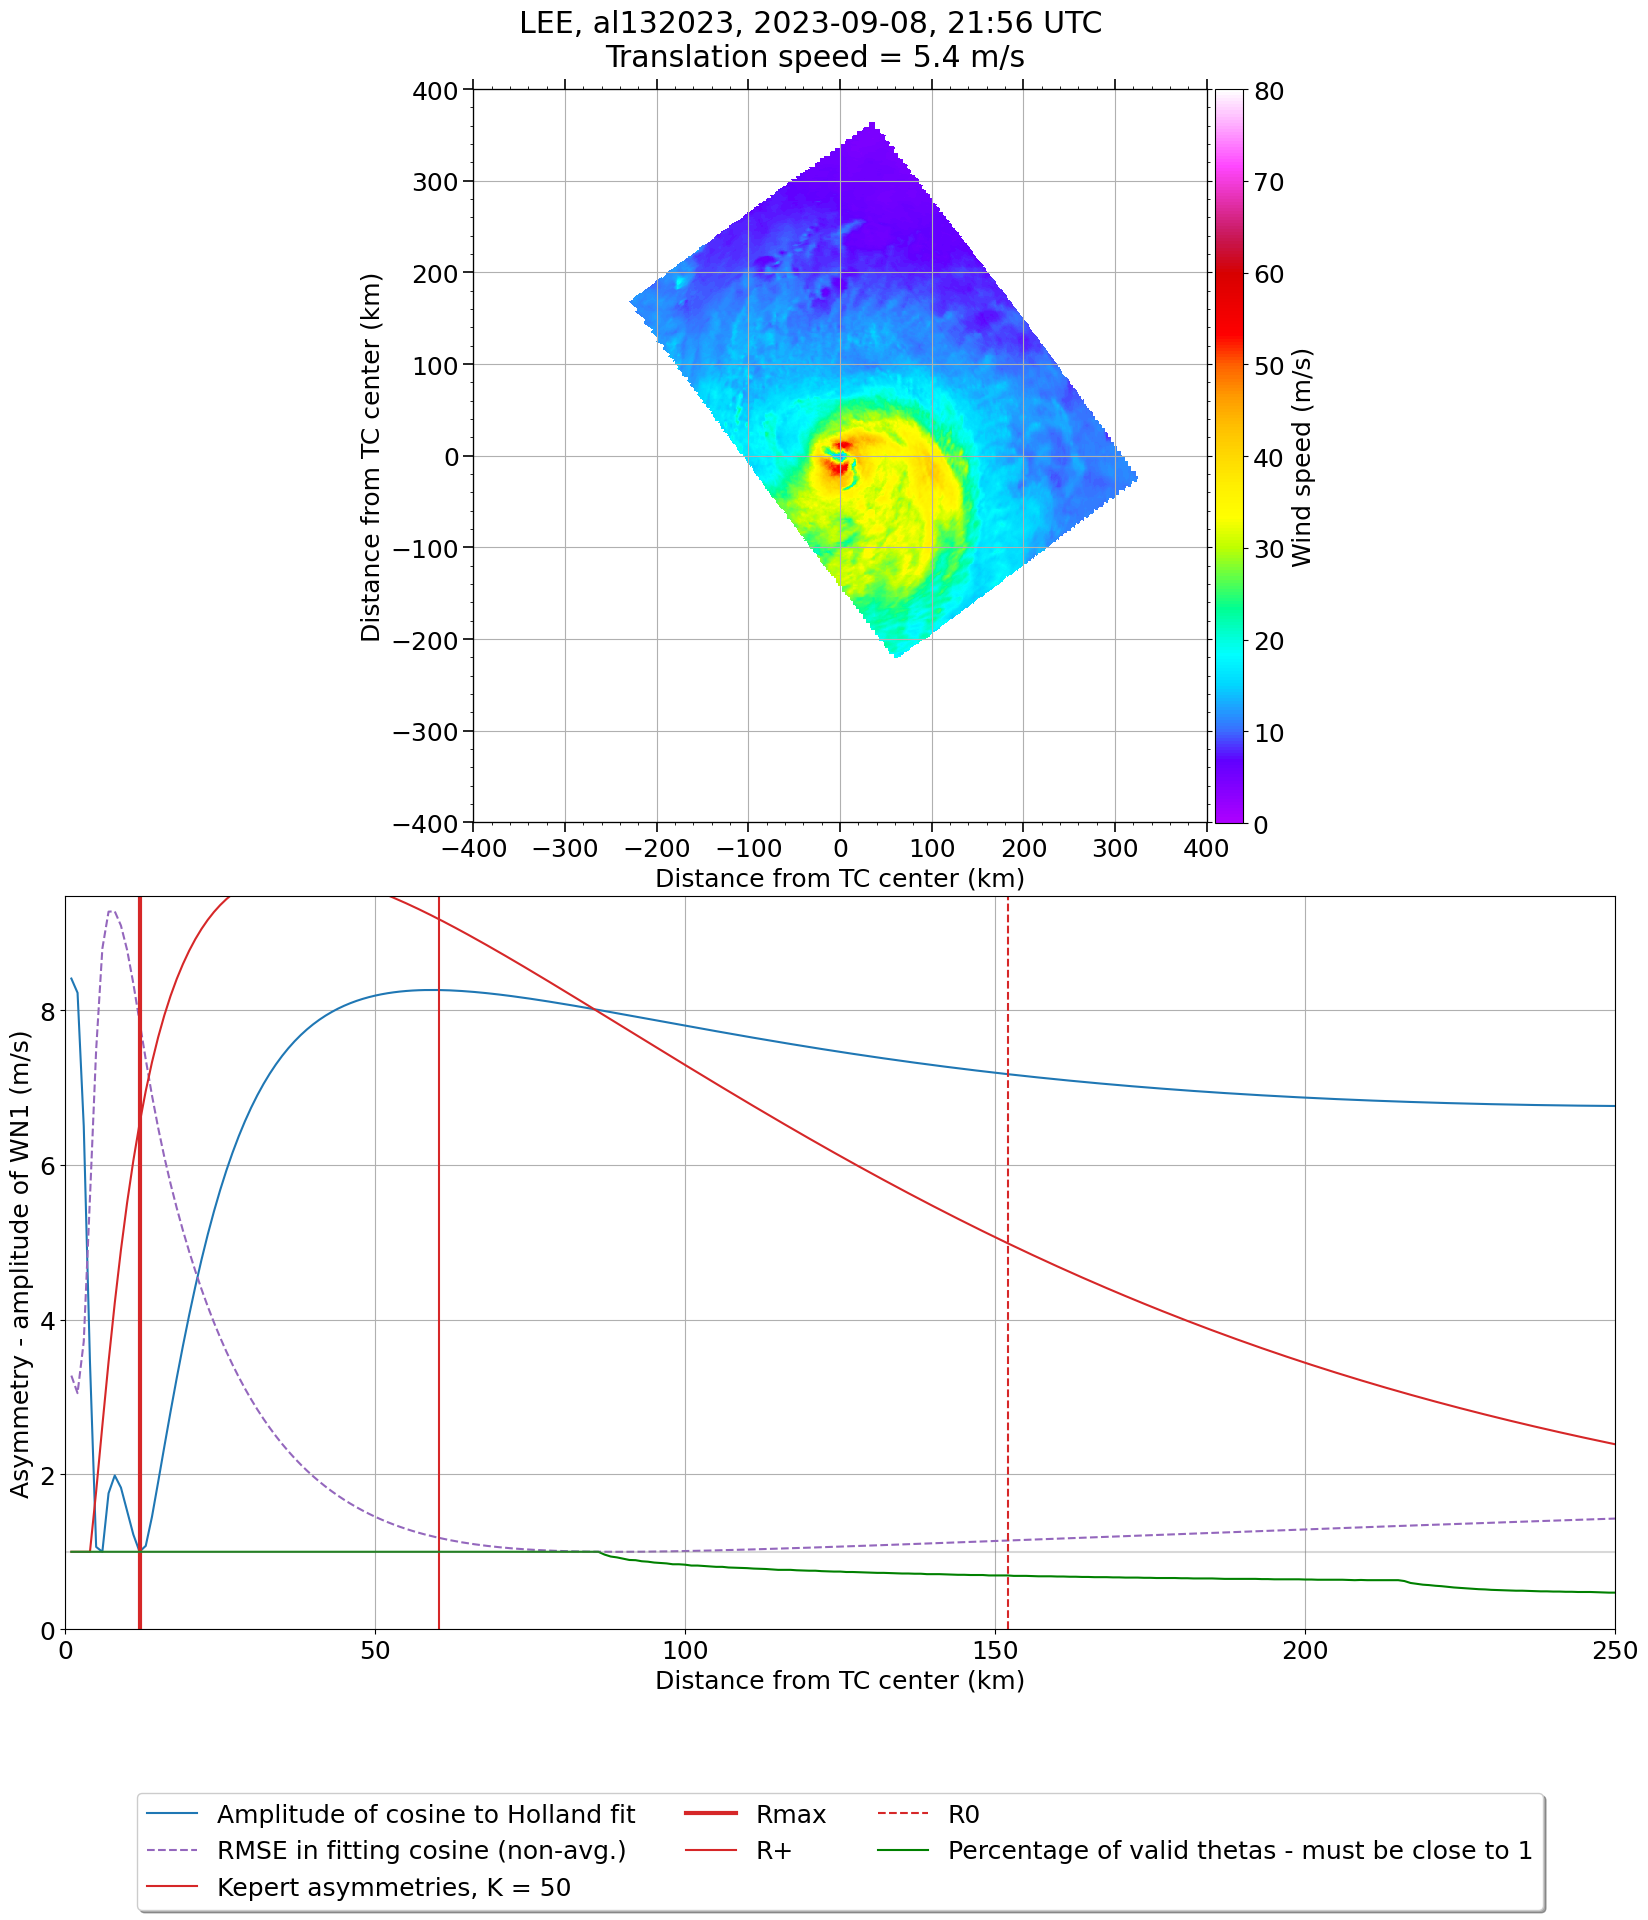

In [111]:
############
### Plot ###
############
fig          = plt.figure(figsize=(20, 20))
gs           = GridSpec(2, 1, hspace=0.1, wspace=0.01)
cmap         = plt.get_cmap('PuOr') # Spectral
normalizer   = Normalize(0, 80)
ax_lims2D    = 400
ts           = pd.to_datetime(str(ds.time.values)) 
d            = ts.strftime('%Y-%m-%d, %H:%M')
plt.suptitle('{}, {}, {} UTC \nTranslation speed = {:.1f} m/s'.format(ds.name.item(), ds.id.item(), d, ds.speed), y=0.92)

### Plot SAR
ax           = fig.add_subplot(gs[0, 0])
dr, th       = np.meshgrid(dsp.rad, np.deg2rad(dsp.theta))
ds_x, ds_y   = pol2cart(dr, th)
ws_car       = griddata((ds_x.flatten(), ds_y.flatten()), np.array(dsp.wind_speed.transpose()).flatten(), (x_ref, y_ref), method='linear')
im           = ax.pcolormesh(x_ref / 1000, y_ref / 1000, ws_car, cmap=cwnd, norm=normalizer)

# Axes
ax.set_xlim(-ax_lims2D, ax_lims2D);ax.set_ylim(-ax_lims2D, ax_lims2D)
ax.set_ylabel(r'Distance from TC center (km)')
ax.set_xlabel(r'Distance from TC center (km)')
ax.set_box_aspect(1)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.grid()

ax2 = ax.twinx().twiny() 
ax2.set_xlim(-ax_lims2D, ax_lims2D);ax2.set_ylim(-ax_lims2D, ax_lims2D)
ax2.minorticks_on()
ax2.tick_params(axis='both', length=7, width=1.2)
ax2.set_box_aspect(1)
ax2.set_yticklabels([])
ax2.set_xticklabels([])

# Colorbar
cb_ax = fig.add_axes([0.7, 0.513, 0.014, 0.367])
cbar  = fig.colorbar(im, cax=cb_ax)
cbar.set_label(r'Wind speed (m/s)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

### Plot asymmetries (SAR + Kepert)
ax       = fig.add_subplot(gs[1, 0])

ax.plot(xs / 1000, ACN, c='tab:blue',                       label='Amplitude of cosine to Holland fit')
ax.plot(xs / 1000, ERR, c='tab:purple', linestyle='dashed', label='RMSE in fitting cosine (non-avg.)')
# Kepert asymmetry profiles
ax.plot(xs / 1000, aks,                 c='tab:red',                        label='Kepert asymmetries, K = {}'.format(K))
# Wind radii
ax.axvline(ds.rmx / 1000,                      c='tab:red',    linewidth=3,        label='Rmax')
ax.axvline(ds.rps / 1000,                      c='tab:red',                        label='R+')
ax.axvline(ds.r0 / 1000,                       c='tab:red',    linestyle='dashed', label='R0')

# # I ~ V/r
# ax.axvline(ds.I_Vr1 / 1000,                    c='orange',                         label='I ~ V/r with SAR wind speed (not BL-top)')
# ax.axvline(ds.I_Vr2 / 1000,                    c='orange')

# Validity curves
ax.plot(xs / 1000, np.array(VTS) / 360., c='green',                          label='Percentage of valid thetas - must be close to 1')
# ax.plot(xs / 1000, Ut / Vs[0, idxs],      c='green',      linestyle='dashed', label='Ut / V - must remain small')
ax.axhline(1, c='gray', alpha=0.3)

# Legends
ax.set_xlabel(r'Distance from TC center (km)')
ax.set_ylabel('Asymmetry - amplitude of WN1 (m/s)')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=3, fancybox=True, shadow=True)
ax.set_xlim(0, max(float(ds.r0 / 1000) + 5, 250))
ax.set_ylim(0, 0.2 + float(max(max(ACN), max(ERR))))
ax.grid()

### 2) Fitting with dropsondes only

Yields different values of C / sqrt(K), c1, and c2; Does not account for the surface wind asymmetry!

In [112]:
dps_all = glob.glob(PTHS['dps_dir'] + '*.nc')

In [113]:
from pyproj import CRS, Geod

### FUNCTIONS
def get_polar_theta(forward_az):
    '''INPUT: forward_az: 0° is North, 90° is East;
    OUTPUT: theta: 0° is East, 90° is North'''
    theta = (90 - forward_az) % 360 # 0° is North, 90° is East
    return theta

def pol2cart(r, th):
    x = r * np.cos(th)
    y = r * np.sin(th)
    return x, y

def get_new_aircraft_coords_based_on_storm_motion(diwp, storm_dir, storm_speed, time_cen, lon_cen, lat_cen):
    '''storm_dir: usually float(ds.storm_dir_ibt), i.e degrees east of north
    storm_speed: usually float(ds.storm_speed_ibt), i.e m/s
    time_cen: usually ds.time, i.e np.datetime64 indicating the time of the considered center point
    lon_cen, lat_cen: usually float(ds.lon) and float(ds.lat), i.e coordinates of the storm center (degrees East and North)
    '''
    # Temps écoulé depuis le temps d'acquisition SAR
    dt              = diwp.time - time_cen
    diwp['dt_scds'] = xr.DataArray(
        data=np.array(dt.dt.days * 24 * 3600 + dt.dt.seconds),
        dims=['time']
    )
    diwp.dt_scds.attrs['description'] = 'Temps écoulé depuis le temps d acquisition SAR'

    # New longitudes/latitudes after moving x meters to a specified direction
    geod_wgs84            = CRS("epsg:4326").get_geod()
    new_lons, new_lats, _ = geod_wgs84.fwd(lons=diwp.lon, lats=diwp.lat, az=np.ones_like(diwp.lon) * storm_dir, dist=-diwp.dt_scds * storm_speed)
    
    diwp['new_lon']       = xr.DataArray(data=new_lons, dims=['time'])
    diwp['new_lat']       = xr.DataArray(data=new_lats, dims=['time'])
    diwp.new_lon.attrs['description'] = 'longitude of the point after correcting for storm motion'
    diwp.new_lat.attrs['description'] = 'latitude of the point after correcting for storm motion'

    # Compute polar coordinates
    geod_wgs84        = CRS("epsg:4326").get_geod()
    forward_az, _, dr = geod_wgs84.inv(np.ones_like(diwp.lon) * lon_cen, np.ones_like(diwp.lat) * lat_cen, diwp.new_lon, diwp.new_lat)
    th                = get_polar_theta(forward_az) # r is dr
    
    diwp['r']         = xr.DataArray(data=dr, dims=['time'])
    diwp['th']        = xr.DataArray(data=th, dims=['time'])
    diwp.r.attrs['description']  = 'radius of the point after correcting for storm motion'
    diwp.th.attrs['description'] = 'azimuth of the point after correcting for storm motion'

    # Compute cartesian coordinates
    x, y      = pol2cart(dr, np.deg2rad(th))
    diwp['x'] = xr.DataArray(data=x, dims=['time'])
    diwp['y'] = xr.DataArray(data=y, dims=['time'])
    diwp.x.attrs['description'] = 'x of the point after correcting for storm motion'
    diwp.y.attrs['description'] = 'y of the point after correcting for storm motion'

    return diwp

  0%|          | 0/31 [00:00<?, ?it/s]

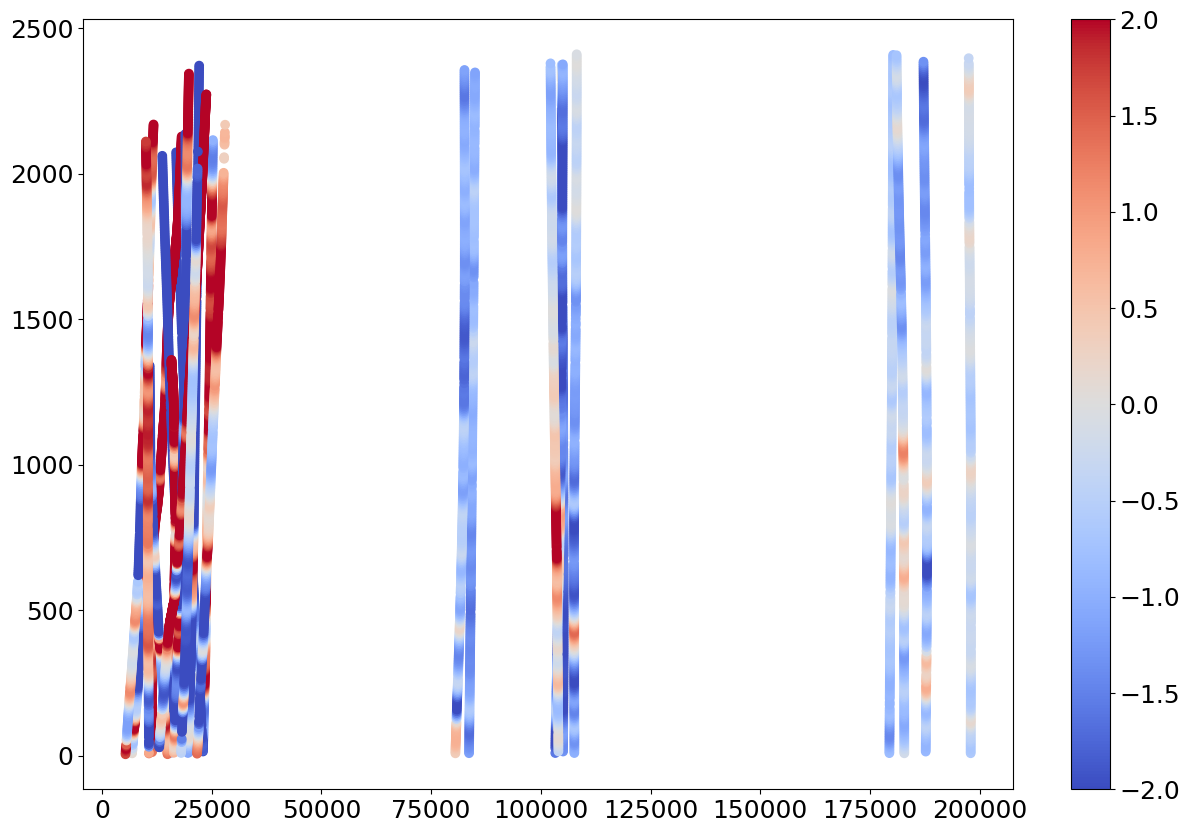

In [114]:
for file in tqdm(dps_all):
    dp        = xr.open_dataset(file)
    dp        = get_new_aircraft_coords_based_on_storm_motion(dp, float(ds.storm_dir_ibt), float(ds.storm_speed_ibt), ds.time, float(ds.lon), float(ds.lat))
    sc        = plt.scatter(dp.r, dp.alt, c=dp.w_wind, cmap='coolwarm', vmin=-2, vmax=2)
plt.colorbar(sc)

In [115]:
dp_z_ref = np.linspace(0, 2000, 401)
DP_RADS  = []
DP_THS   = []
DP_HWS   = []

for file in tqdm(dps_all):
    try:
        dp        = xr.open_dataset(file)
        # Correct for storm movement and time difference
        dp        = get_new_aircraft_coords_based_on_storm_motion(dp, float(ds.storm_dir_ibt), float(ds.storm_speed_ibt), ds.time, float(ds.lon), float(ds.lat))
        # Add total wind speed
        dp['hws'] = np.sqrt(dp.u_wind ** 2 + dp.v_wind ** 2)
        # Interpolate on dp_z_ref
        ds_dp = xr.DataArray(data=np.array(dp.dropna(dim='time').hws), coords={'z': np.array(dp.dropna(dim='time').gpsalt)})
        ds_dp = ds_dp.where(~np.isnan(ds_dp.z)).dropna(dim='z') # Remove potential NaNs on coord z
        DP_HWS.append(np.array(ds_dp.interp(coords={'z': dp_z_ref})))
        # Add (r, th)-mean-coordinates
        DP_RADS.append(float(dp.r.mean()))
        DP_THS.append(float(dp.th.mean()))
    except ValueError:
        print('failed for file {}'.format(file))

# Concatenate in one big array
DP_OBS  = np.full((len(dp_z_ref), len(DP_THS), len(DP_RADS)), np.nan)
for idx in range(len(DP_RADS)):
    DP_OBS[:, idx, idx] = DP_HWS[idx]

  0%|          | 0/31 [00:00<?, ?it/s]

failed for file /home/arthur/data/tropical_cyclones/dropsondes/NOAA_field_experiment/samples/al132023/20230908H1_NETCDF/D20230909_014833_PQC.nc
failed for file /home/arthur/data/tropical_cyclones/dropsondes/NOAA_field_experiment/samples/al132023/20230908H1_NETCDF/D20230909_003248_PQC.nc
failed for file /home/arthur/data/tropical_cyclones/dropsondes/NOAA_field_experiment/samples/al132023/20230908H1_NETCDF/D20230908_234103_PQC.nc
failed for file /home/arthur/data/tropical_cyclones/dropsondes/NOAA_field_experiment/samples/al132023/20230908H1_NETCDF/D20230909_003514QC.nc
failed for file /home/arthur/data/tropical_cyclones/dropsondes/NOAA_field_experiment/samples/al132023/20230908H1_NETCDF/D20230909_001041_PQC.nc


In [116]:
def get_rmse_wrt_dps(optim_params, THs, Rs, Zs, ths, rs, zs, Vs, fcr, z_ref, h, DP_OBS, DP_RADS, DP_THS, dp_z_ref):
    # Extraire les paramètres à optimiser
    K, C, c1, c2 = optim_params

    # Wind at gradient level
    wrf    = wind_reduction_factor(Rs, Vs, K, C, fcr) # azimuthal wind
    Vs_try = Vs / wrf

    # Get K25
    u_K25, v_K25 = kepert2025(THs, Rs, Vs_try, K, C, c1, c2, fcr, Zs, z_ref, h)

    # Get polar dataset
    kep_pol      = get_xrDataset_polar(zs, ths, rs, u_K25, v_K25)

    return rmse(kep_pol.interp(coords={'rad': DP_RADS, 'theta': DP_THS, 'z': dp_z_ref}).wind_speed, DP_OBS)

In [117]:
### FITTING OF OPTIMAL PARAMETERS
### CAVEAT: Use the low-resolution reference grids!!
### Otherwise this will last too long
initial_guess = [50, 1.5e-3, 0.1, 0.1] 
bounds        = [(0, 200), (1e-4, 1e-2), (-10., 10.), (-10., 10.)] # (min, max) pour chaque paramètre
fixed_args    = (THs, Rs, Zs, ths, rs, zs, Vs, fcr, z_ref, h, DP_OBS, DP_RADS, DP_THS, dp_z_ref)

#   - `method`: L'algorithme de minimisation. 'Nelder-Mead' est un bon choix pour commencer,
#               mais 'L-BFGS-B' est souvent efficace si vous avez des bornes.
result        = minimize(get_rmse_wrt_dps, initial_guess, args=fixed_args, method='L-BFGS-B', bounds=bounds) # Takes ~2.5 mins

In [118]:
# Afficher les résultats
if result.success:
    K_opt, C_opt, c1_opt, c2_opt = result.x
    print("Optimisation réussie !")
    print(f"K optimisé : {K_opt:.4f}")
    print(f"C optimisé : {C_opt:.4f}")
    print(f"c1 optimisé : {c1_opt:.4f}")
    print(f"c2 optimisé : {c2_opt:.4f}")
    print(f"RMSE final : {result.fun:.4f}")
    print(f"c1 / c2 : {c1_opt / c2_opt:.4f}")
    print(f"C / sqrt(K) : {C_opt / np.sqrt(K_opt):.5f}")
else:
    print("L'optimisation a échoué.")
    print(result.message)

Optimisation réussie !
K optimisé : 49.8588
C optimisé : 0.0028
c1 optimisé : 1.6235
c2 optimisé : -2.0971
RMSE final : 9.8983
c1 / c2 : -0.7742
C / sqrt(K) : 0.00040


In [119]:
### Extract the solution
# Wind at gradient level
wrf    = wind_reduction_factor(Rs, Vs, K_opt, C_opt, fcr) # azimuthal wind
Vs_try = Vs / wrf

# Get K25
u_K25, v_K25 = kepert2025(THs, Rs, Vs_try, K_opt, C_opt, c1_opt, c2_opt, fcr, Zs, z_ref, h)

# Get polar dataset
kep_pol      = get_xrDataset_polar(zs, ths, rs, u_K25, v_K25)

  0%|          | 0/31 [00:00<?, ?it/s]

(0.0, 250000.0)

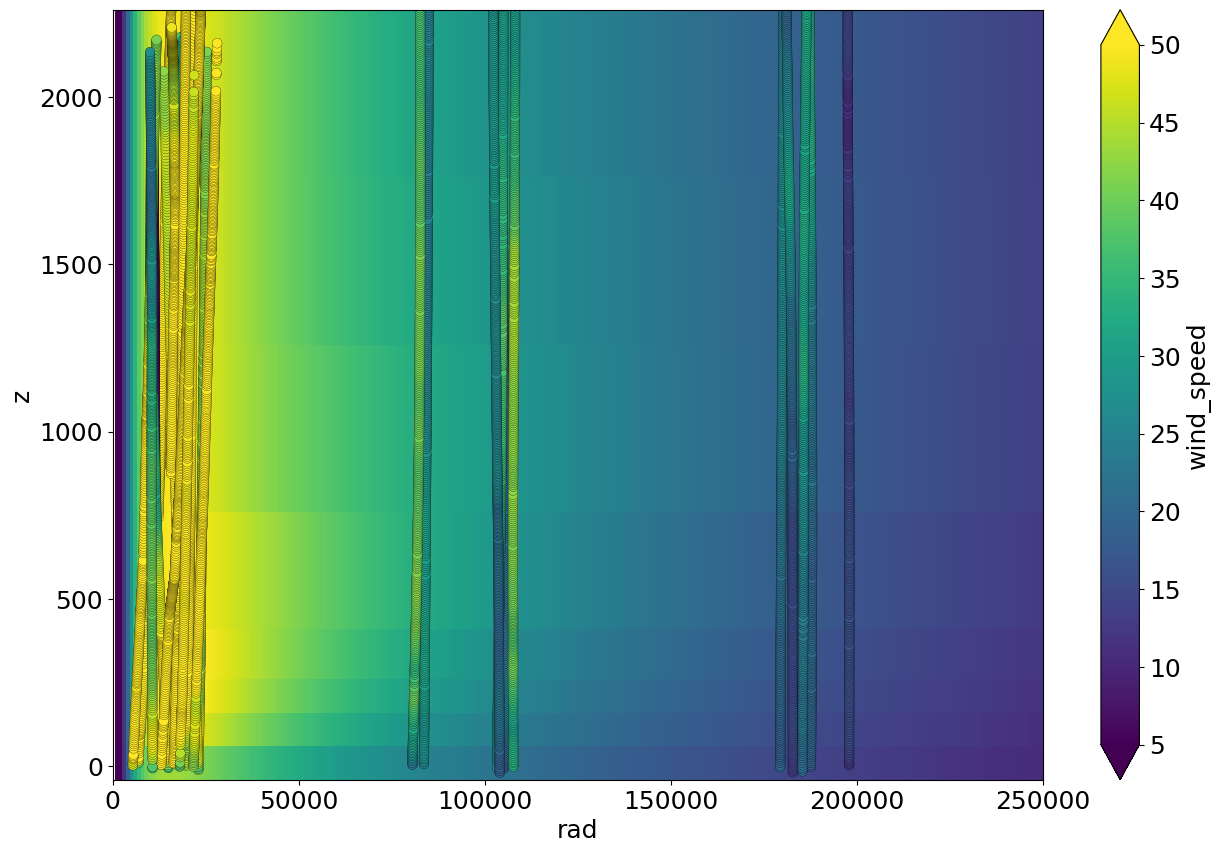

In [120]:
cvmax = 50

kep_pol.mean(dim='theta').wind_speed.plot(vmin=5, vmax=cvmax, cmap='viridis')
# dsp.wind_speed.transpose().plot(vmin=5, vmax=40, cmap='viridis')
for file in tqdm(dps_all):
    dp        = xr.open_dataset(file)
    dp        = get_new_aircraft_coords_based_on_storm_motion(dp, float(ds.storm_dir_ibt), float(ds.storm_speed_ibt), ds.time, float(ds.lon), float(ds.lat))
    dp['hws'] = np.sqrt(dp.u_wind ** 2 + dp.v_wind ** 2)
    plt.scatter(dp.r, dp.gpsalt, c=dp.hws, vmin=5, vmax=cvmax, cmap='viridis', edgecolor='black', linewidth=0.2, s=50)
plt.xlim(0, 250000)

  0%|          | 0/250 [00:00<?, ?it/s]

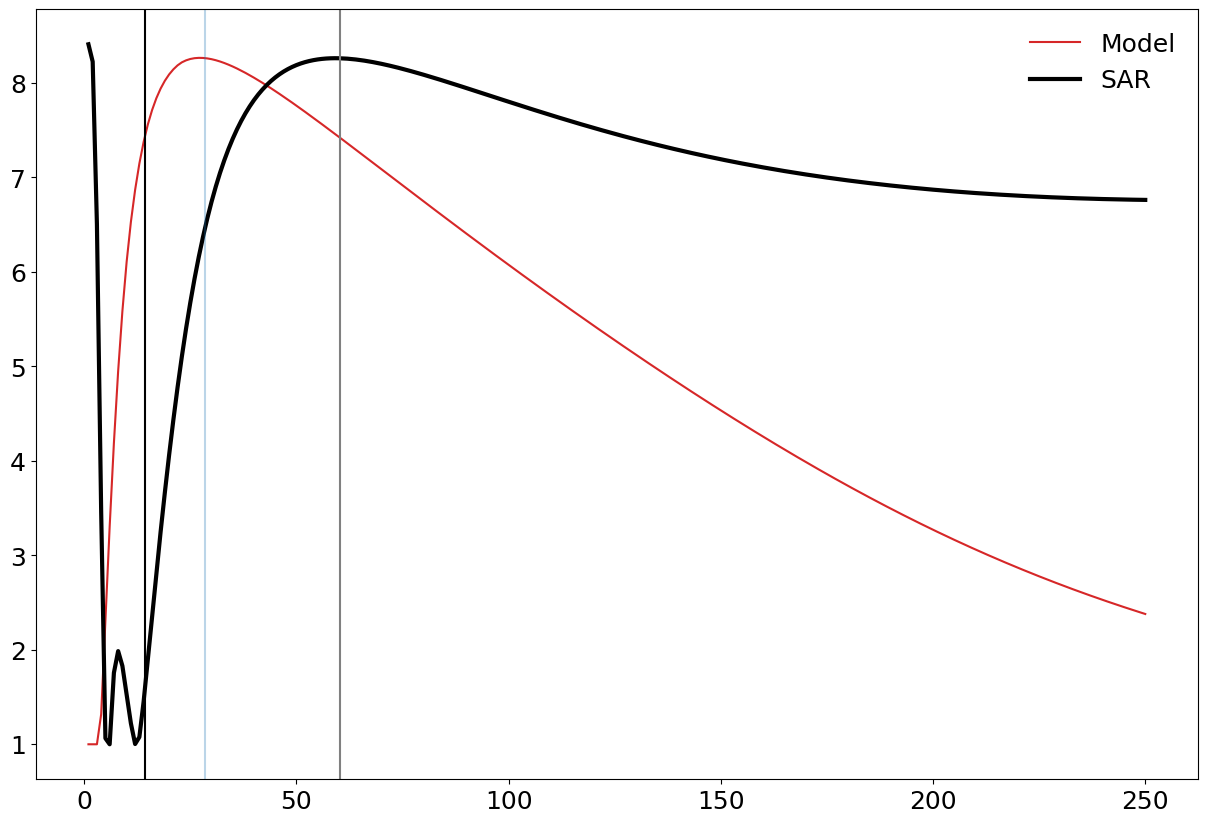

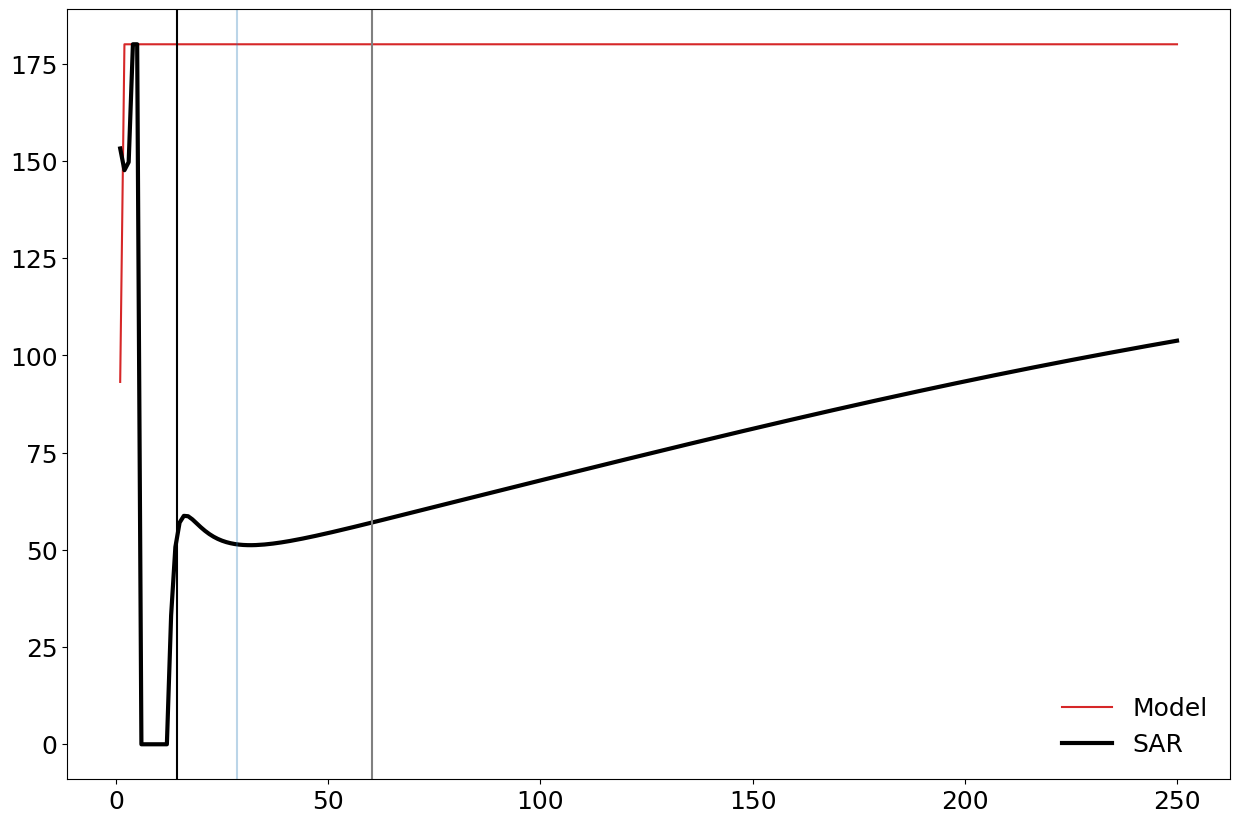

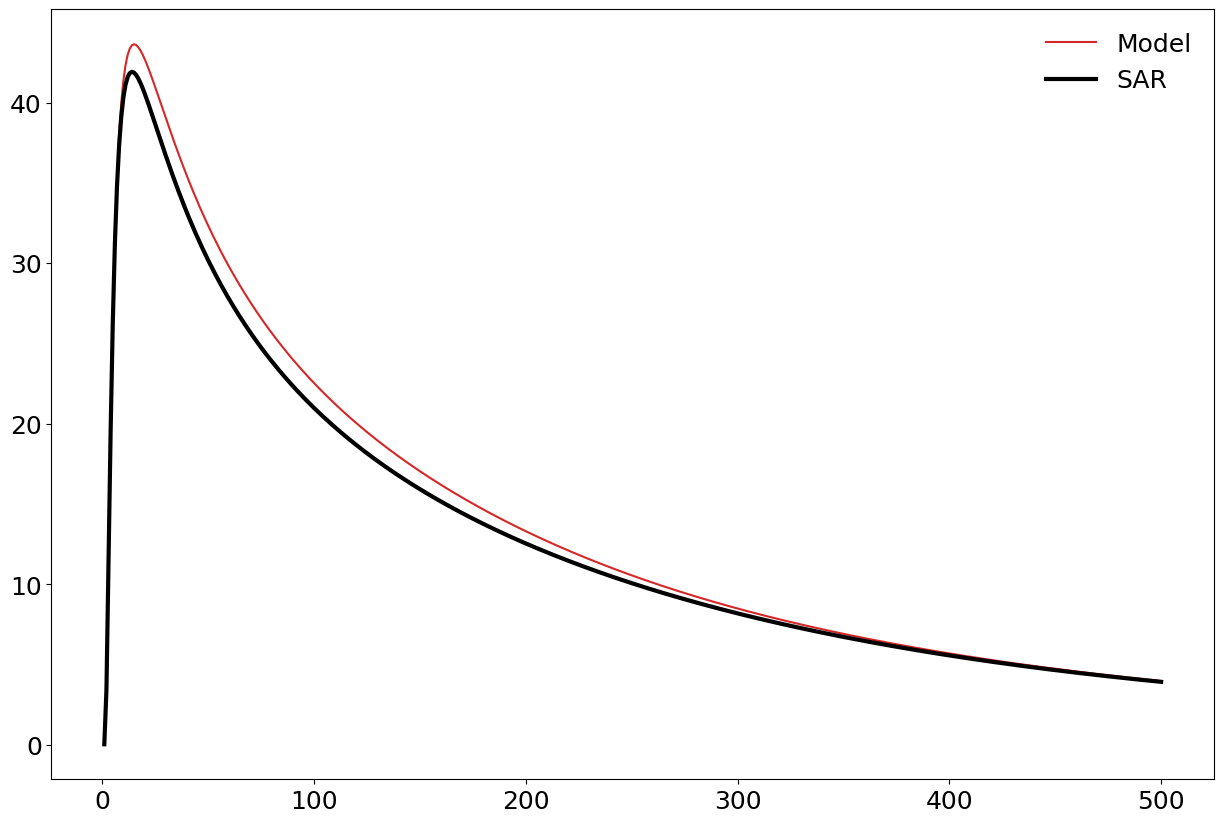

In [121]:
### Asymmetries and wind profile
# Compute asymmetries on Kepert wind field
aks         = []
pks         = []
# Iterate over all radii
for rad in tqdm(xs): # Iterate only in the valid range to optimize time
    ak, phi, _  = get_wn1(np.deg2rad(kep_pol.sel(z=10).theta), kep_pol.sel(z=10).wind_speed.sel(rad=rad, method='nearest'), np.max(Vs[0, 0, :]) / 3, np.max(Vs[0, 0, :]))
    aks.append(ak)
    pks.append(phi)

# Asymmetry amplitude
plt.plot(xs / 1000, aks, c='tab:red', label='Model')
plt.plot(xs / 1000, ACN, c='k', linewidth=3, label='SAR')
plt.axvline(rmx / 1000,        c='k')
plt.axvline(ds.rps / 1000,     c='gray')
plt.axvline(2 * rmx / 1000,    c='tab:blue', alpha=0.3)
plt.legend(frameon=False)
plt.show()

# Asymmetry phase
plt.plot(xs / 1000,  np.rad2deg(pks), c='tab:red', label='Model')
plt.plot(xs / 1000, np.rad2deg(PHS), c='k', linewidth=3, label='SAR')
plt.axvline(rmx / 1000,        c='k')
plt.axvline(ds.rps / 1000,     c='gray')
plt.axvline(2 * rmx / 1000,    c='tab:blue', alpha=0.3)
plt.legend(frameon=False)
plt.show()

# Wind profile
plt.plot(rs / 1000,  kep_pol.sel(z=10).wind_speed.mean(dim='theta'), c='tab:red', label='Model')
plt.plot(rs / 1000, Vs[0, 0, :], c='k', linewidth=3, label='SAR')
plt.legend(frameon=False)

### 3) Fitting with SAR only

Yields approximate values of c1 and c2, as well as C / sqrt(K)

In [86]:
def get_rmse_wrt_sar(optim_params, THs_sar, Rs_sar, Zs_sar, ths, rs, zs_sar, Vs_sar, fcr, z_ref, h, dsp_sar):
    # Extraire les paramètres à optimiser
    K, C, c1, c2 = optim_params

    # Wind at gradient level
    wrf        = wind_reduction_factor(Rs_sar, Vs_sar, K, C, fcr) # azimuthal wind
    Vs_try_sar = Vs_sar / wrf

    # Get K25
    u_K25, v_K25 = kepert2025(THs_sar, Rs_sar, Vs_try_sar, K, C, c1, c2, fcr, Zs_sar, z_ref, h)

    # Get polar dataset
    kep_pol      = get_xrDataset_polar(zs_sar, ths, rs, u_K25, v_K25)

    return float(rmse(kep_pol.interp(coords={'rad': np.array(dsp_sar.wind_speed.transpose().rad)}).sel(theta=slice(0, 359)).wind_speed, dsp_sar.wind_speed.transpose()))

In [85]:
# Redefine grids to compute only at surface 
Rs_sar, THs_sar = np.meshgrid(rs, ths)                                   # shape (361, 5000)
zs_sar          = np.array([10])
THs_sar         = np.repeat(np.expand_dims(THs_sar, axis=0), len(zs_sar), axis=0) # shape e.g (len(zs), 361, 5000)
Rs_sar          = np.repeat(np.expand_dims(Rs_sar, axis=0), len(zs_sar), axis=0)  # shape e.g (len(zs), 361, 5000)
Zs_sar          = np.repeat(np.expand_dims(zs_sar, axis=1), len(ths), axis=1) # shape e.g (len(zs), 361, 5000)
Zs_sar          = np.repeat(np.expand_dims(Zs_sar, axis=2), len(rs), axis=2)  # shape e.g (len(zs), 361, 5000)

# Redefine Vs
Vs_sar   = np.stack([V for i in range(np.shape(THs_sar)[1])]) # Shape (361, 5000)
Vs_sar   = np.repeat(np.expand_dims(Vs_sar, axis=0), len(zs_sar), axis=0)

In [88]:
### FITTING OF OPTIMAL PARAMETERS
### CAVEAT: Use the low-resolution reference grids!!
### Otherwise this will last too long
initial_guess = [50, 1.5e-3, 0.1, 0.1] 
bounds        = [(0, 200), (1e-4, 1e-2), (-10., 10.), (-10., 10.)] # (min, max) pour chaque paramètre
fixed_args    = (THs_sar, Rs_sar, Zs_sar, ths, rs, zs_sar, Vs_sar, fcr, z_ref, h, dsp)

#   - `method`: L'algorithme de minimisation. 'Nelder-Mead' est un bon choix pour commencer,
#               mais 'L-BFGS-B' est souvent efficace si vous avez des bornes.
result        = minimize(get_rmse_wrt_sar, initial_guess, args=fixed_args, method='L-BFGS-B', bounds=bounds) # Takes less than 30 seconds

In [89]:
# Afficher les résultats
if result.success:
    K_opt, C_opt, c1_opt, c2_opt = result.x
    print("Optimisation réussie !")
    print(f"K optimisé : {K_opt:.4f}")
    print(f"C optimisé : {C_opt:.4f}")
    print(f"c1 optimisé : {c1_opt:.4f}")
    print(f"c2 optimisé : {c2_opt:.4f}")
    print(f"RMSE final : {result.fun:.4f}")
    print(f"c1 / c2 : {c1_opt / c2_opt:.4f}")
    print(f"C / sqrt(K) : {C_opt / np.sqrt(K_opt):.5f}")
else:
    print("L'optimisation a échoué.")
    print(result.message)

Optimisation réussie !
K optimisé : 49.9998
C optimisé : 0.0007
c1 optimisé : -2.1321
c2 optimisé : 1.3166
RMSE final : 5.0358
c1 / c2 : -1.6194
C / sqrt(K) : 0.00010


In [91]:
### Extract the solution
# Wind at gradient level
wrf    = wind_reduction_factor(Rs, Vs, K_opt, C_opt, fcr) # azimuthal wind
Vs_try = Vs / wrf

# Get K25
u_K25, v_K25 = kepert2025(THs, Rs, Vs_try, K_opt, C_opt, c1_opt, c2_opt, fcr, Zs, z_ref, h)

# Get polar dataset
kep_pol      = get_xrDataset_polar(zs, ths, rs, u_K25, v_K25)

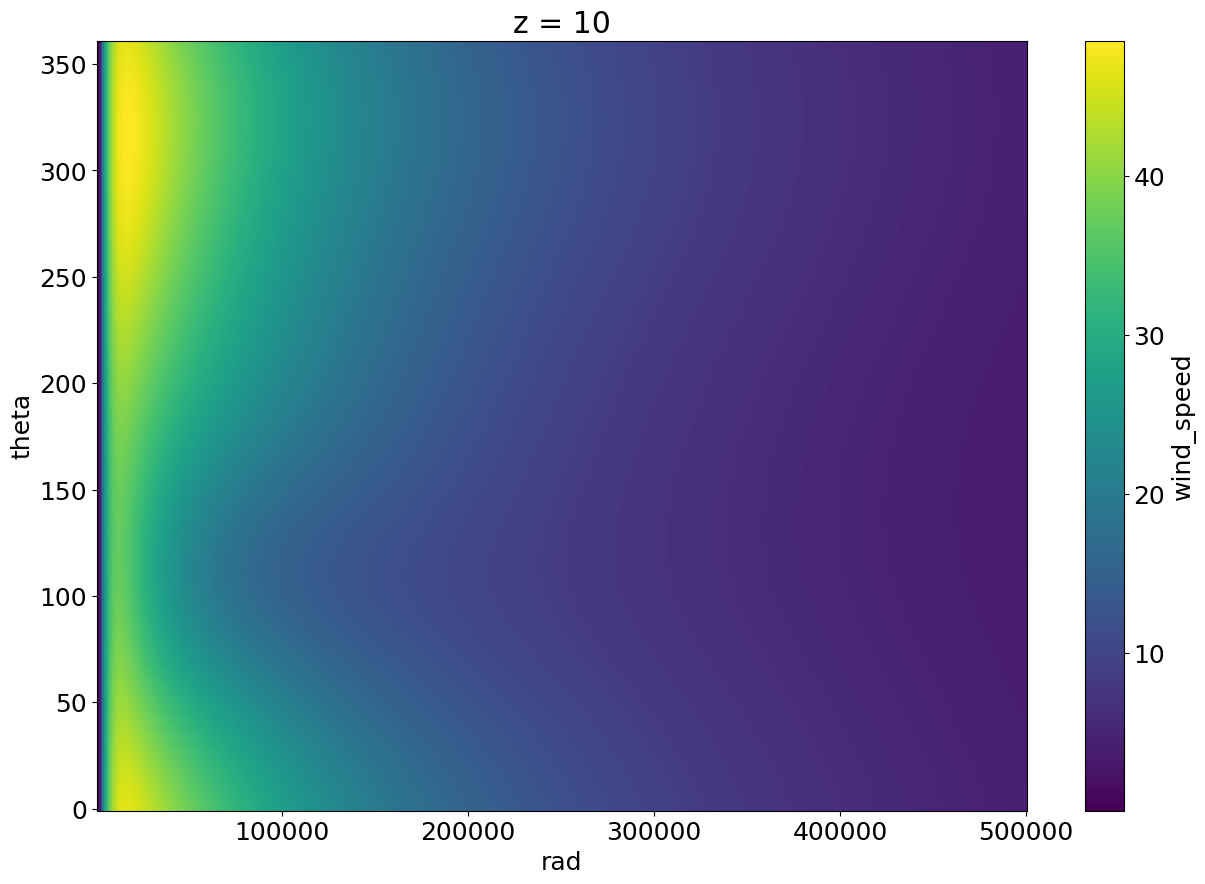

In [94]:
kep_pol.sel(z=10).wind_speed.plot()

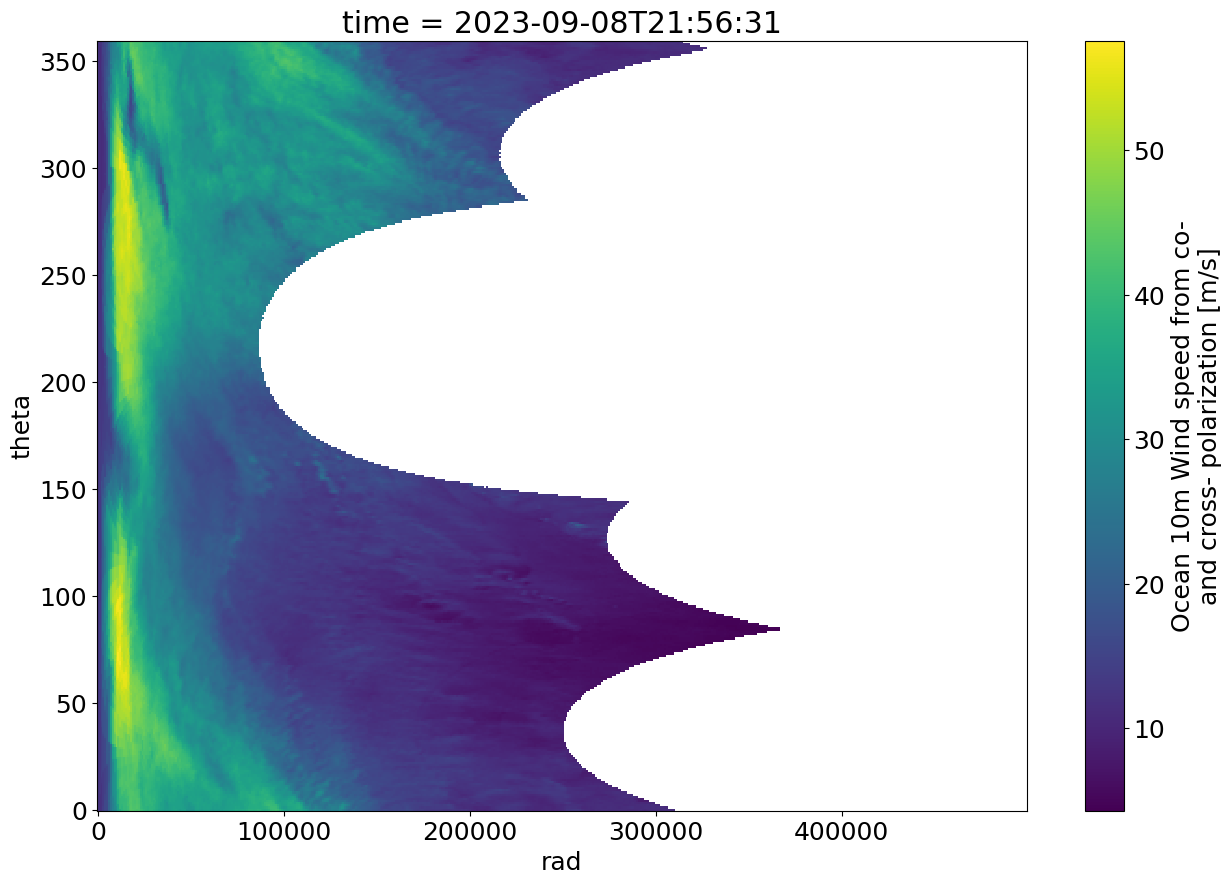

In [90]:
dsp.wind_speed.transpose().plot()

  0%|          | 0/250 [00:00<?, ?it/s]

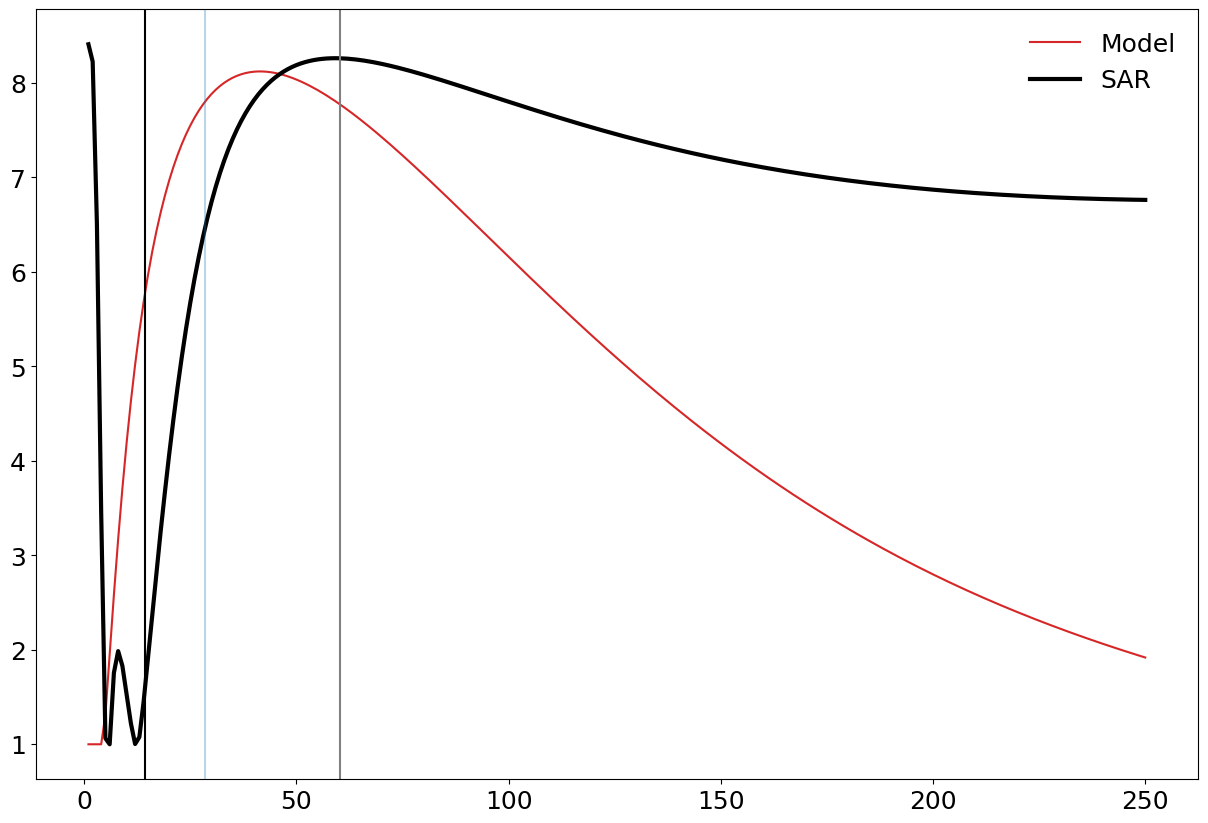

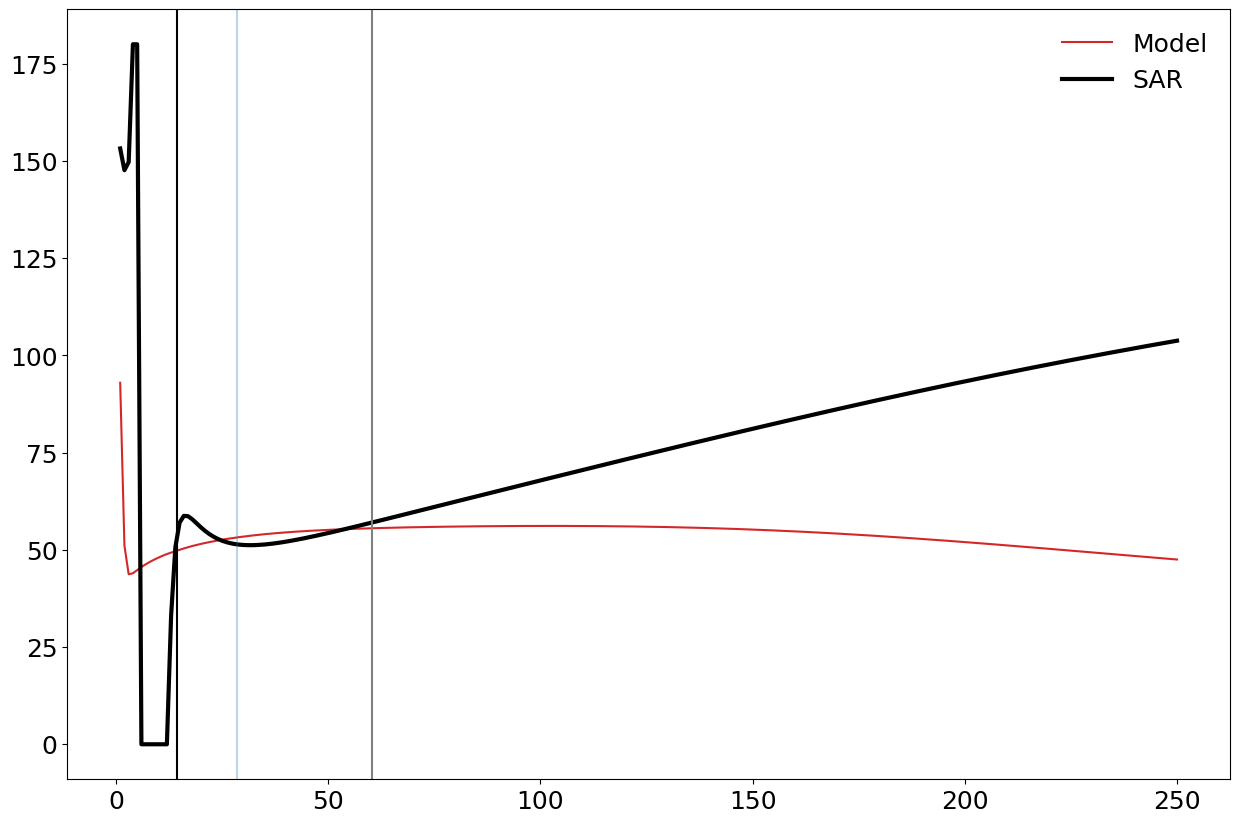

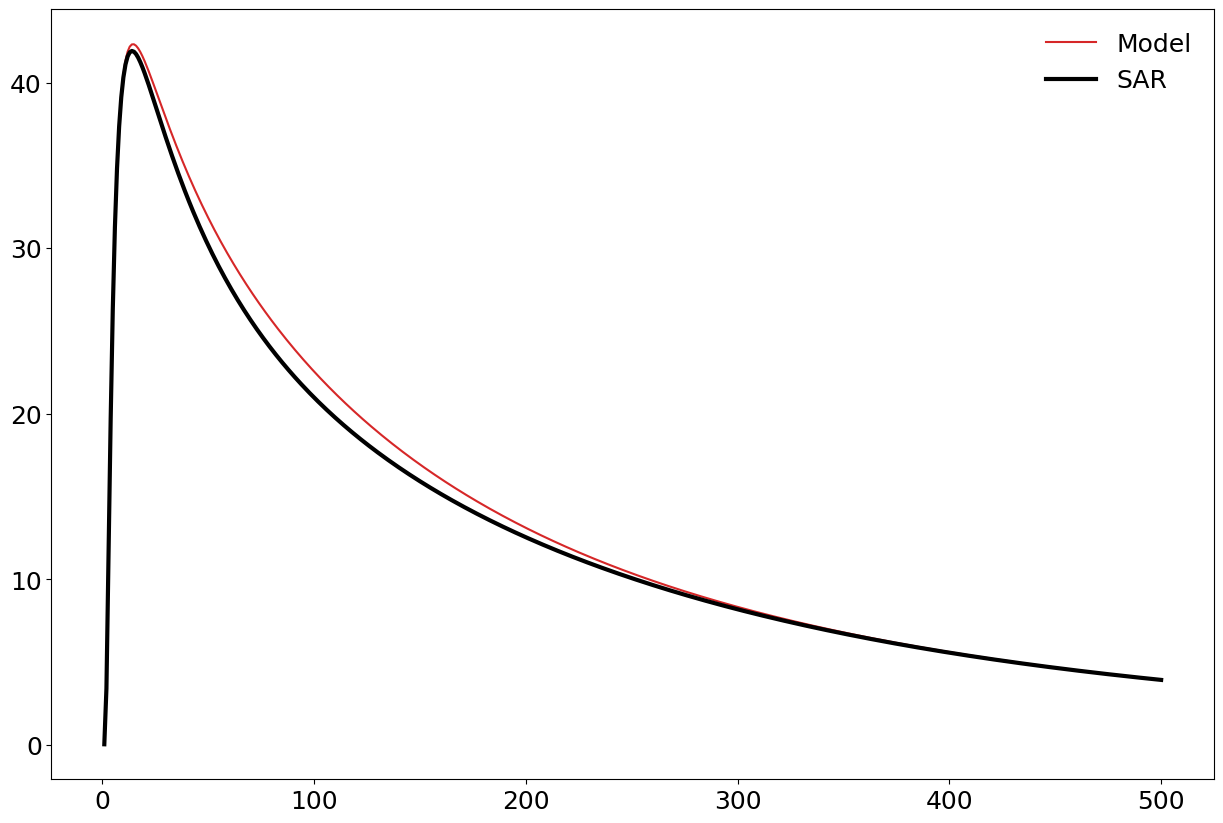

In [95]:
### Asymmetries and wind profile
# Compute asymmetries on Kepert wind field
aks         = []
pks         = []
# Iterate over all radii
for rad in tqdm(xs): # Iterate only in the valid range to optimize time
    ak, phi, _  = get_wn1(np.deg2rad(kep_pol.sel(z=10).theta), kep_pol.sel(z=10).wind_speed.sel(rad=rad, method='nearest'), np.max(Vs[0, 0, :]) / 3, np.max(Vs[0, 0, :]))
    aks.append(ak)
    pks.append(phi)

# Asymmetry amplitude
plt.plot(xs / 1000, aks, c='tab:red', label='Model')
plt.plot(xs / 1000, ACN, c='k', linewidth=3, label='SAR')
plt.axvline(rmx / 1000,        c='k')
plt.axvline(ds.rps / 1000,     c='gray')
plt.axvline(2 * rmx / 1000,    c='tab:blue', alpha=0.3)
plt.legend(frameon=False)
plt.show()

# Asymmetry phase
plt.plot(xs / 1000,  np.rad2deg(pks), c='tab:red', label='Model')
plt.plot(xs / 1000, np.rad2deg(PHS), c='k', linewidth=3, label='SAR')
plt.axvline(rmx / 1000,        c='k')
plt.axvline(ds.rps / 1000,     c='gray')
plt.axvline(2 * rmx / 1000,    c='tab:blue', alpha=0.3)
plt.legend(frameon=False)
plt.show()

# Wind profile
plt.plot(rs / 1000,  kep_pol.sel(z=10).wind_speed.mean(dim='theta'), c='tab:red', label='Model')
plt.plot(rs / 1000, Vs[0, 0, :], c='k', linewidth=3, label='SAR')
plt.legend(frameon=False)

#### 3bis) Fitting (C/sqrt(K), c1, c2) with SAR only

In [127]:
def get_rmse_wrt_sar_fixedK(optim_params, K, THs_sar, Rs_sar, Zs_sar, ths, rs, zs_sar, Vs_sar, fcr, z_ref, h, dsp_sar):
    # Extraire les paramètres à optimiser
    C, c1, c2 = optim_params

    # Wind at gradient level
    wrf        = wind_reduction_factor(Rs_sar, Vs_sar, K, C, fcr) # azimuthal wind
    Vs_try_sar = Vs_sar / wrf

    # Get K25
    u_K25, v_K25 = kepert2025(THs_sar, Rs_sar, Vs_try_sar, K, C, c1, c2, fcr, Zs_sar, z_ref, h)

    # Get polar dataset
    kep_pol      = get_xrDataset_polar(zs_sar, ths, rs, u_K25, v_K25)

    return float(rmse(kep_pol.interp(coords={'rad': np.array(dsp_sar.wind_speed.transpose().rad)}).sel(theta=slice(0, 359)).wind_speed, dsp_sar.wind_speed.transpose()))

In [126]:
# Redefine grids to compute only at surface 
Rs_sar, THs_sar = np.meshgrid(rs, ths)                                            # shape (361, 5000)
zs_sar          = np.array([10])
THs_sar         = np.repeat(np.expand_dims(THs_sar, axis=0), len(zs_sar), axis=0) # shape e.g (len(zs), 361, 5000)
Rs_sar          = np.repeat(np.expand_dims(Rs_sar, axis=0), len(zs_sar), axis=0)  # shape e.g (len(zs), 361, 5000)
Zs_sar          = np.repeat(np.expand_dims(zs_sar, axis=1), len(ths), axis=1)     # shape e.g (len(zs), 361, 5000)
Zs_sar          = np.repeat(np.expand_dims(Zs_sar, axis=2), len(rs), axis=2)      # shape e.g (len(zs), 361, 5000)

# Redefine Vs
Vs_sar   = np.stack([V for i in range(np.shape(THs_sar)[1])]) # Shape (361, 5000)
Vs_sar   = np.repeat(np.expand_dims(Vs_sar, axis=0), len(zs_sar), axis=0)

In [149]:
### FITTING OF OPTIMAL PARAMETERS
### CAVEAT: Use the low-resolution reference grids!!
### Otherwise this will last too long
fixed_K       = 200
initial_guess = [1.5e-3, 0.1, 0.1] 
bounds        = [(1e-4, 1e-2), (-10., 10.), (-10., 10.)] # (min, max) pour chaque paramètre
fixed_args    = (fixed_K, THs_sar, Rs_sar, Zs_sar, ths, rs, zs_sar, Vs_sar, fcr, z_ref, h, dsp)

#   - `method`: L'algorithme de minimisation. 'Nelder-Mead' est un bon choix pour commencer,
#               mais 'L-BFGS-B' est souvent efficace si vous avez des bornes.
result        = minimize(get_rmse_wrt_sar_fixedK, initial_guess, args=fixed_args, method='L-BFGS-B', bounds=bounds) # Takes less than 30 seconds

In [150]:
# Afficher les résultats
if result.success:
    C_opt, c1_opt, c2_opt = result.x
    print("Optimisation réussie !")
    print(f"K optimisé : {fixed_K:.0f}")
    print(f"C optimisé : {C_opt:.4f}")
    print(f"c1 optimisé : {c1_opt:.4f}")
    print(f"c2 optimisé : {c2_opt:.4f}")
    print(f"RMSE final : {result.fun:.4f}")
    print(f"c1 / c2 : {c1_opt / c2_opt:.4f}")
    print(f"C / sqrt(K) : {C_opt / np.sqrt(fixed_K):.5f}")
else:
    print("L'optimisation a échoué.")
    print(result.message)

Optimisation réussie !
K optimisé : 200
C optimisé : 0.0014
c1 optimisé : -2.2308
c2 optimisé : 1.3231
RMSE final : 5.0355
c1 / c2 : -1.6860
C / sqrt(K) : 0.00010


In [141]:
# Optimisation réussie !
# K optimisé : 1
# C optimisé : 0.0001
# c1 optimisé : -2.1667
# c2 optimisé : 1.2965
# RMSE final : 5.0355
# c1 / c2 : -1.6713
# C / sqrt(K) : 0.00010

In [142]:
# Optimisation réussie !
# K optimisé : 20
# C optimisé : 0.0004
# c1 optimisé : -2.2319
# c2 optimisé : 1.3236
# RMSE final : 5.0355
# c1 / c2 : -1.6863
# C / sqrt(K) : 0.00010

In [143]:
# Optimisation réussie !
# K optimisé : 50
# C optimisé : 0.0007
# c1 optimisé : -2.1321
# c2 optimisé : 1.3166
# RMSE final : 5.0358
# c1 / c2 : -1.6194
# C / sqrt(K) : 0.00010

In [ ]:
# Optimisation réussie !
# K optimisé : 100
# C optimisé : 0.0009
# c1 optimisé : -2.3782
# c2 optimisé : 1.3488
# RMSE final : 5.0358
# c1 / c2 : -1.7632
# C / sqrt(K) : 0.00009

In [148]:
# Optimisation réussie !
# K optimisé : 150
# C optimisé : 0.0012
# c1 optimisé : -2.2308
# c2 optimisé : 1.3231
# RMSE final : 5.0355
# c1 / c2 : -1.6860
# C / sqrt(K) : 0.00010

In [151]:
# Optimisation réussie !
# K optimisé : 200
# C optimisé : 0.0014
# c1 optimisé : -2.2308
# c2 optimisé : 1.3231
# RMSE final : 5.0355
# c1 / c2 : -1.6860
# C / sqrt(K) : 0.00010

In [91]:
### Extract the solution
# Wind at gradient level
wrf    = wind_reduction_factor(Rs, Vs, K_opt, C_opt, fcr) # azimuthal wind
Vs_try = Vs / wrf

# Get K25
u_K25, v_K25 = kepert2025(THs, Rs, Vs_try, K_opt, C_opt, c1_opt, c2_opt, fcr, Zs, z_ref, h)

# Get polar dataset
kep_pol      = get_xrDataset_polar(zs, ths, rs, u_K25, v_K25)

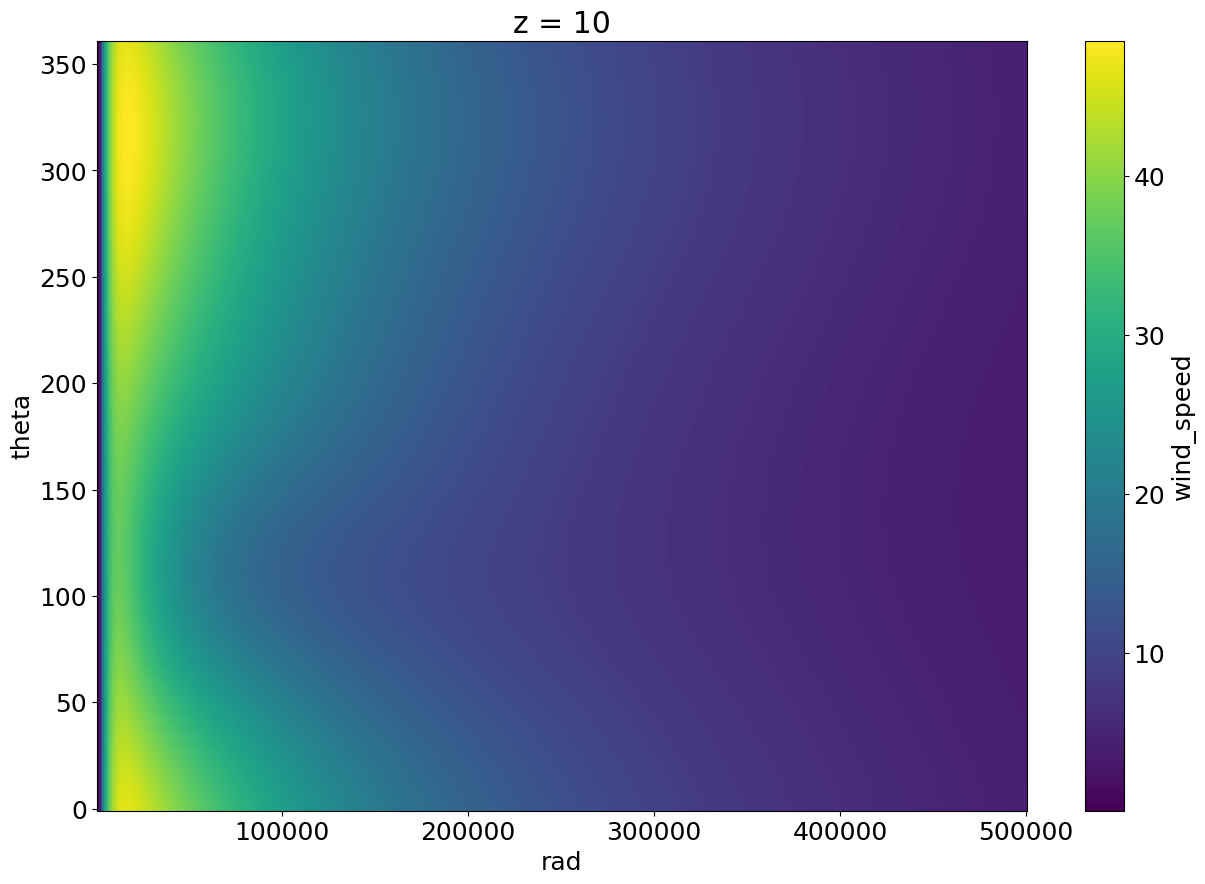

In [94]:
kep_pol.sel(z=10).wind_speed.plot()

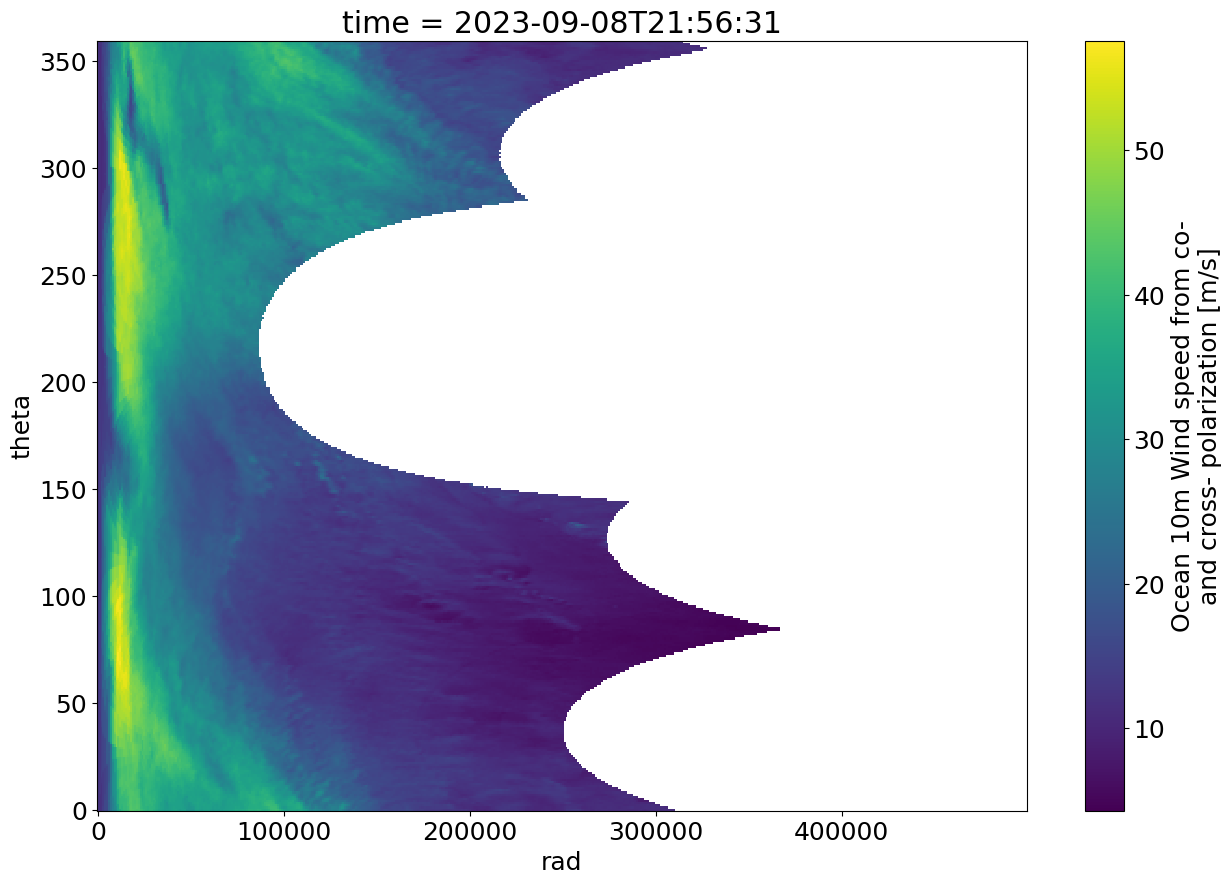

In [90]:
dsp.wind_speed.transpose().plot()

  0%|          | 0/250 [00:00<?, ?it/s]

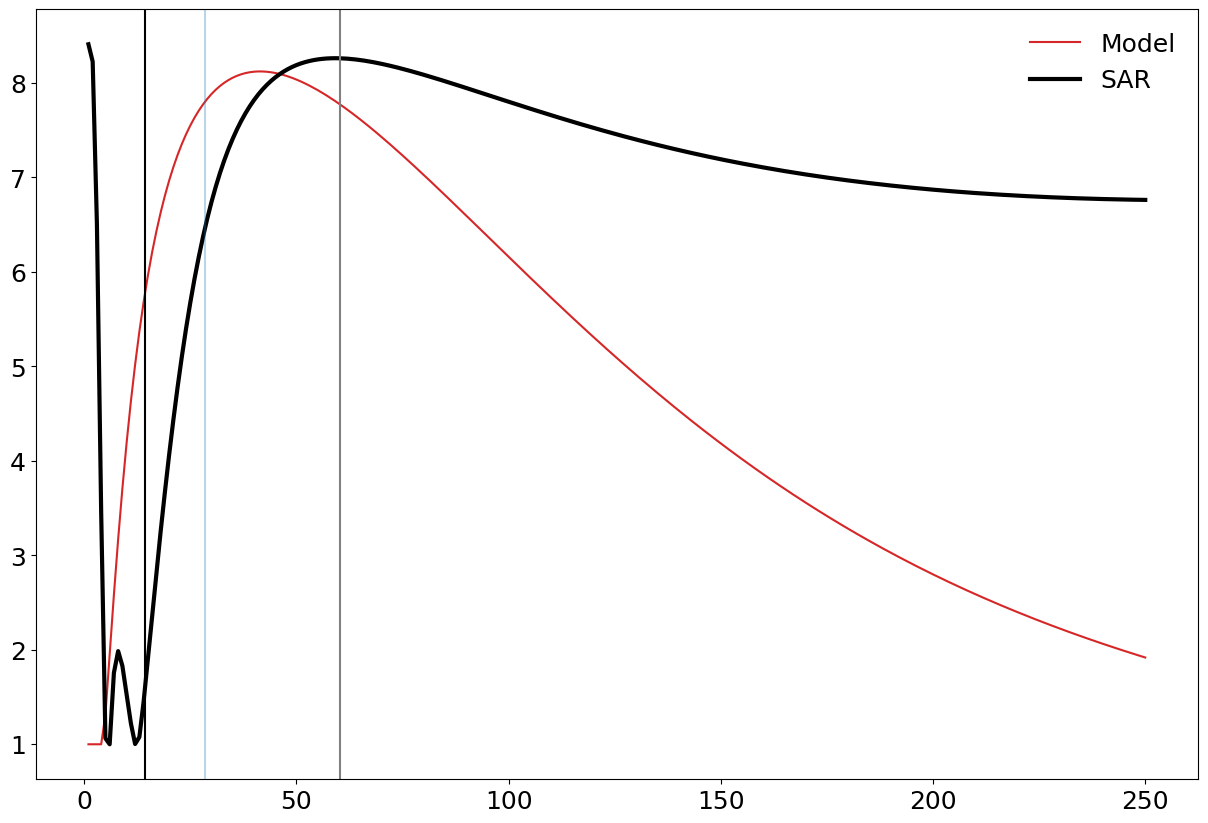

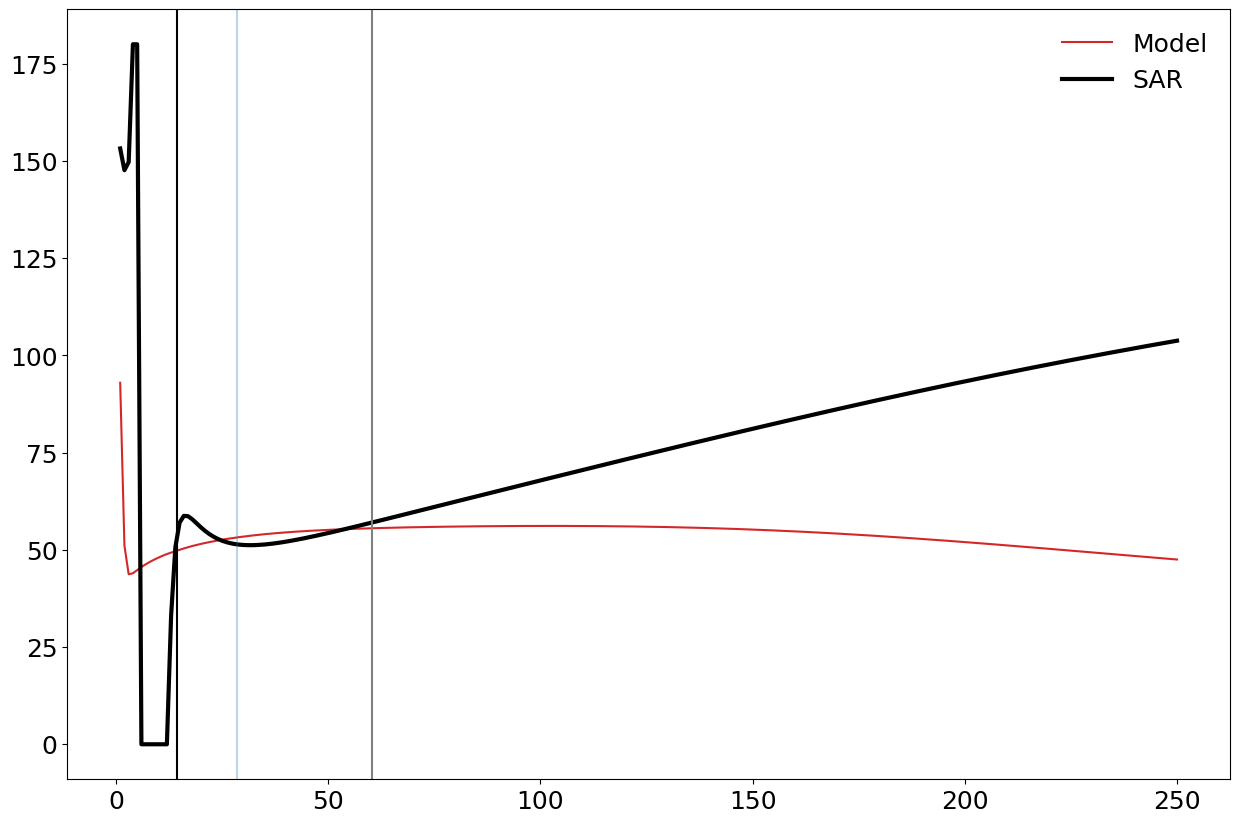

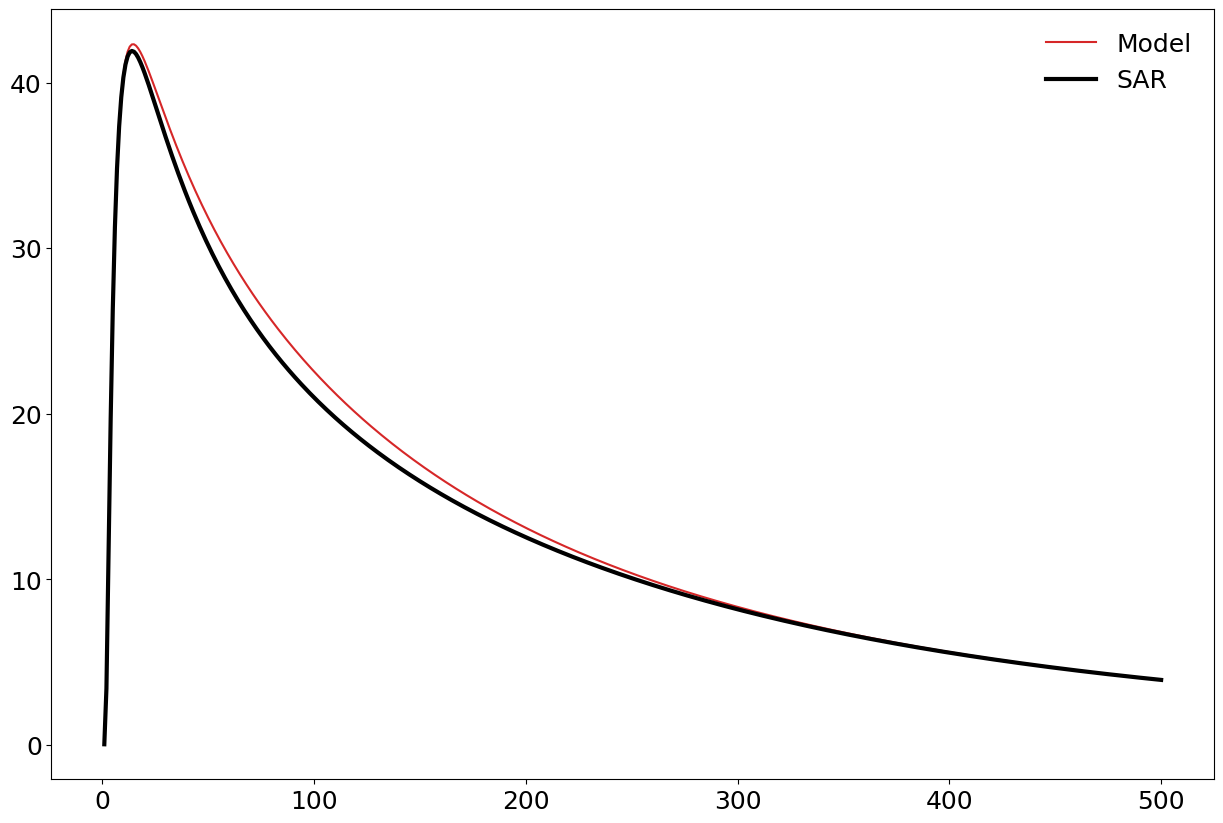

In [95]:
### Asymmetries and wind profile
# Compute asymmetries on Kepert wind field
aks         = []
pks         = []
# Iterate over all radii
for rad in tqdm(xs): # Iterate only in the valid range to optimize time
    ak, phi, _  = get_wn1(np.deg2rad(kep_pol.sel(z=10).theta), kep_pol.sel(z=10).wind_speed.sel(rad=rad, method='nearest'), np.max(Vs[0, 0, :]) / 3, np.max(Vs[0, 0, :]))
    aks.append(ak)
    pks.append(phi)

# Asymmetry amplitude
plt.plot(xs / 1000, aks, c='tab:red', label='Model')
plt.plot(xs / 1000, ACN, c='k', linewidth=3, label='SAR')
plt.axvline(rmx / 1000,        c='k')
plt.axvline(ds.rps / 1000,     c='gray')
plt.axvline(2 * rmx / 1000,    c='tab:blue', alpha=0.3)
plt.legend(frameon=False)
plt.show()

# Asymmetry phase
plt.plot(xs / 1000,  np.rad2deg(pks), c='tab:red', label='Model')
plt.plot(xs / 1000, np.rad2deg(PHS), c='k', linewidth=3, label='SAR')
plt.axvline(rmx / 1000,        c='k')
plt.axvline(ds.rps / 1000,     c='gray')
plt.axvline(2 * rmx / 1000,    c='tab:blue', alpha=0.3)
plt.legend(frameon=False)
plt.show()

# Wind profile
plt.plot(rs / 1000,  kep_pol.sel(z=10).wind_speed.mean(dim='theta'), c='tab:red', label='Model')
plt.plot(rs / 1000, Vs[0, 0, :], c='k', linewidth=3, label='SAR')
plt.legend(frameon=False)

### 4) Fitting with both DPs and SAR

Assumes that all necessary datasets were created before.

Conclusion: il faut normaliser C et K, mais au moins je trouve la même chose à chaque fois, sauf si le K initial change vraiment trop (par exemple de 80 à 160).

In [6]:
def get_rmse_wrt_all(optim_params, THs, Rs, Zs, ths, rs, zs, Vs, fcr, z_ref, h, DP_OBS, DP_RADS, DP_THS, dp_z_ref, dsp_sar, norms=(20, 1e-3)):
    # Extraire les paramètres à optimiser
    K, C, c1, c2   = optim_params
    K_norm, C_norm = norms
    K             *= K_norm
    C             *= C_norm

    # Wind at gradient level
    wrf    = wind_reduction_factor(Rs, Vs, K, C, fcr) # azimuthal wind
    Vs_try = Vs / wrf

    # Get K25
    u_K25, v_K25 = kepert2025(THs, Rs, Vs_try, K, C, c1, c2, fcr, Zs, z_ref, h)

    # Get polar dataset
    kep_pol      = get_xrDataset_polar(zs, ths, rs, u_K25, v_K25)

    # Compute RMSEs
    rmse_dps = float(rmse(kep_pol.interp(coords={'rad': DP_RADS, 'theta': DP_THS, 'z': dp_z_ref}).wind_speed, DP_OBS))
    rmse_sar = float(rmse(kep_pol.sel(z=10).interp(coords={'rad': np.array(dsp_sar.wind_speed.transpose().rad)}).sel(theta=slice(0, 359)).wind_speed, dsp_sar.wind_speed.transpose()))

    return rmse_dps + rmse_sar
    # return rmse_dps + 2 * rmse_sar

In [134]:
### FITTING OF OPTIMAL PARAMETERS
### CAVEAT: Use the low-resolution reference grids!!
### Otherwise this will last too long
# initial_guess = [50, 1.5e-3, 0.1, 0.1] 
# bounds        = [(0, 200), (1e-4, 1e-2), (-10., 10.), (-10., 10.)] # (min, max) pour chaque paramètre
# fixed_args    = (THs, Rs, Zs, ths, rs, zs, Vs, fcr, z_ref, h, DP_OBS, DP_RADS, DP_THS, dp_z_ref, dsp)

# We normalize the parameters (at least K and C)!!
initial_guess = [8, 1., 0.1, 0.1] 
bounds        = [(0.05, 10), (0.1, 10), (-10., 10.), (-10., 10.)] # (min, max) pour chaque paramètre
K_norm        = 20
C_norm        = 1e-3
fixed_args    = (THs, Rs, Zs, ths, rs, zs, Vs, fcr, z_ref, h, DP_OBS, DP_RADS, DP_THS, dp_z_ref, dsp, (K_norm, C_norm))

#   - `method`: L'algorithme de minimisation. 'Nelder-Mead' est un bon choix pour commencer,
#               mais 'L-BFGS-B' est souvent efficace si vous avez des bornes.
result        = minimize(get_rmse_wrt_all, initial_guess, args=fixed_args, method='L-BFGS-B', bounds=bounds) # Takes ~3 mins

In [135]:
# Afficher les résultats
if result.success:
    K_opt, C_opt, c1_opt, c2_opt = result.x
    K_opt *= K_norm
    C_opt *= C_norm
    print("Optimisation réussie !")
    print(f"K optimisé : {K_opt:.4f}")
    print(f"C optimisé : {C_opt:.4f}")
    print(f"c1 optimisé : {c1_opt:.4f}")
    print(f"c2 optimisé : {c2_opt:.4f}")
    print(f"RMSE final : {result.fun:.4f}")
    print(f"c1 / c2 : {c1_opt / c2_opt:.4f}")
    print(f"C / sqrt(K) : {C_opt / np.sqrt(K_opt):.5f}")
else:
    print("L'optimisation a échoué.")
    print(result.message)

Optimisation réussie !
K optimisé : 6.3115
C optimisé : 0.0011
c1 optimisé : -0.8043
c2 optimisé : 0.9385
RMSE final : 15.4964
c1 / c2 : -0.8570
C / sqrt(K) : 0.00046


In [136]:
# ### Resultats si je prends en initial guess K=160 et 1 * rmse_sar:
# Optimisation réussie !
# K optimisé : 6.3115
# C optimisé : 0.0011
# c1 optimisé : -0.8043
# c2 optimisé : 0.9385
# RMSE final : 15.4964
# c1 / c2 : -0.8570
# C / sqrt(K) : 0.00046

In [133]:
# ### Resultats si je prends en initial guess K=80 et 1 * rmse_sar:
# Optimisation réussie !
# K optimisé : 1.0000
# C optimisé : 0.0005
# c1 optimisé : -0.8864
# c2 optimisé : 0.8976
# RMSE final : 15.4354
# c1 / c2 : -0.9875
# C / sqrt(K) : 0.00046

In [132]:
# ### Resultats si je prends en initial guess K=80 et 2 * rmse_sar:
# Optimisation réussie !
# K optimisé : 1.0000
# C optimisé : 0.0005
# c1 optimisé : -0.8864
# c2 optimisé : 0.8976
# RMSE final : 20.5412
# c1 / c2 : -0.9875
# C / sqrt(K) : 0.00046

In [137]:
### Extract the solution
# Wind at gradient level
wrf    = wind_reduction_factor(Rs, Vs, K_opt, C_opt, fcr) # azimuthal wind
Vs_try = Vs / wrf

# Get K25
u_K25, v_K25 = kepert2025(THs, Rs, Vs_try, K_opt, C_opt, c1_opt, c2_opt, fcr, Zs, z_ref, h)

# Get polar dataset
kep_pol      = get_xrDataset_polar(zs, ths, rs, u_K25, v_K25)

  0%|          | 0/31 [00:00<?, ?it/s]

(0.0, 250000.0)

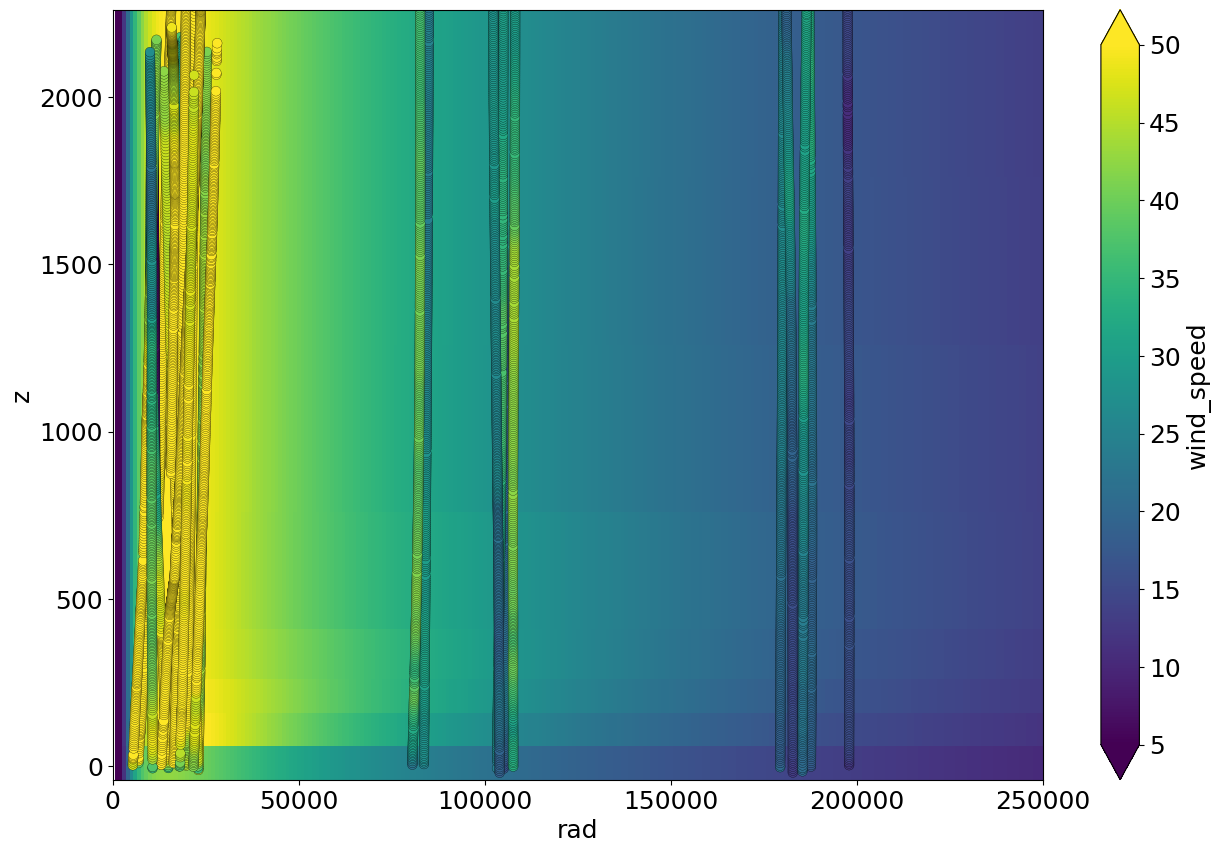

In [138]:
cvmax = 50

kep_pol.mean(dim='theta').wind_speed.plot(vmin=5, vmax=cvmax, cmap='viridis')
# dsp.wind_speed.transpose().plot(vmin=5, vmax=40, cmap='viridis')
for file in tqdm(dps_all):
    dp        = xr.open_dataset(file)
    dp        = get_new_aircraft_coords_based_on_storm_motion(dp, float(ds.storm_dir_ibt), float(ds.storm_speed_ibt), ds.time, float(ds.lon), float(ds.lat))
    dp['hws'] = np.sqrt(dp.u_wind ** 2 + dp.v_wind ** 2)
    plt.scatter(dp.r, dp.gpsalt, c=dp.hws, vmin=5, vmax=cvmax, cmap='viridis', edgecolor='black', linewidth=0.2, s=50)
plt.xlim(0, 250000)

  0%|          | 0/250 [00:00<?, ?it/s]

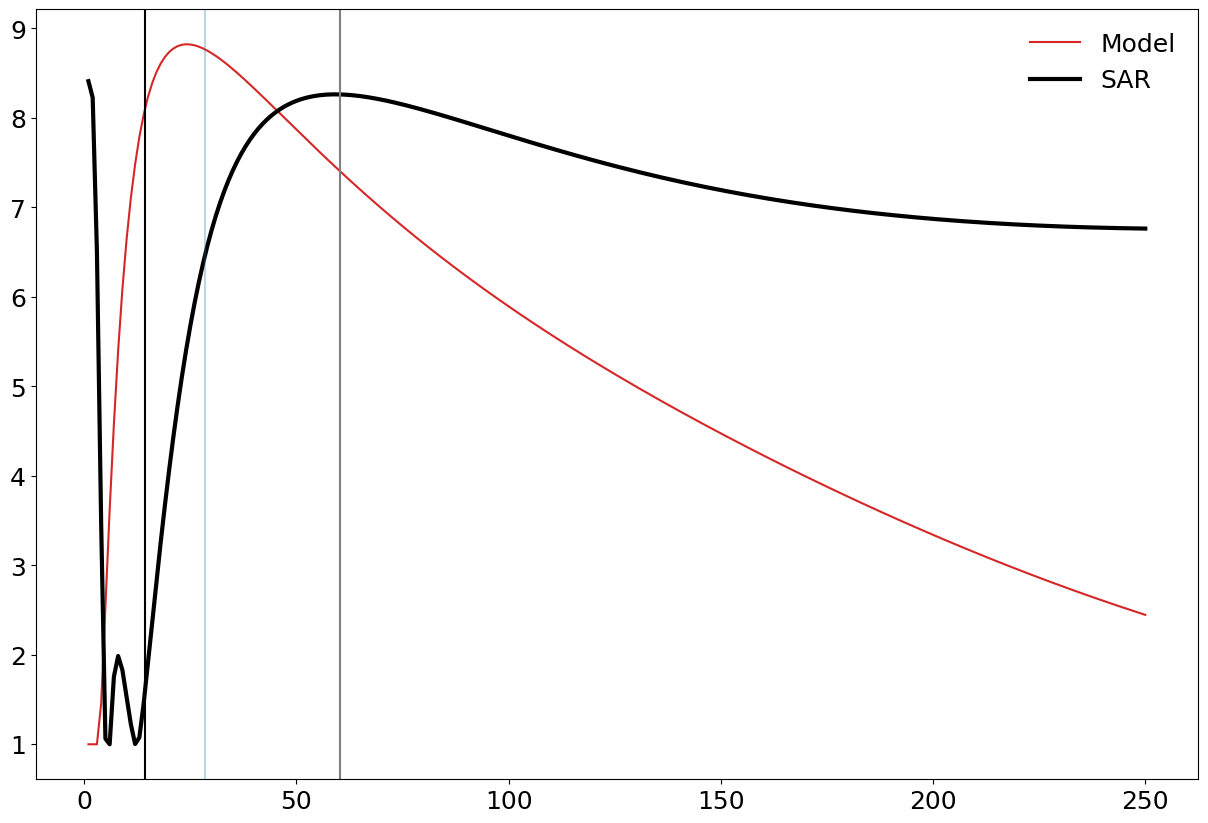

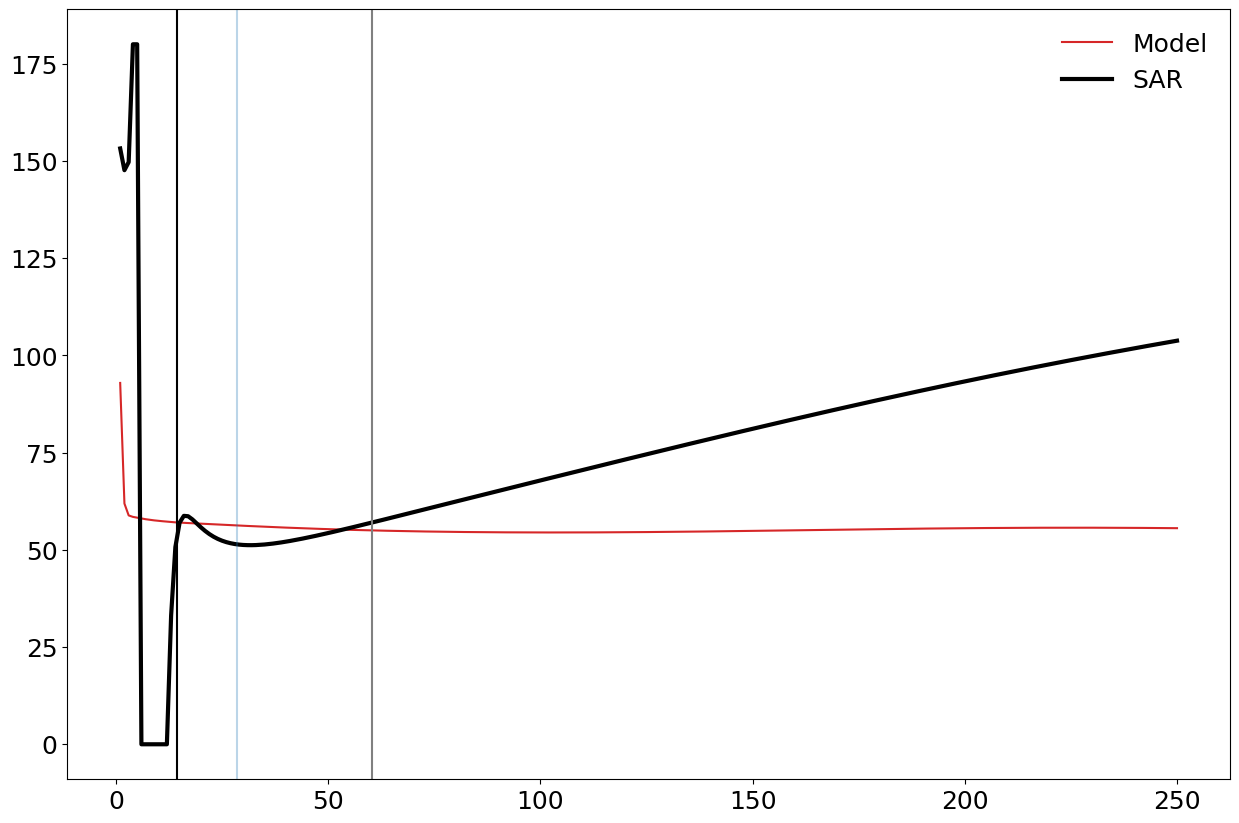

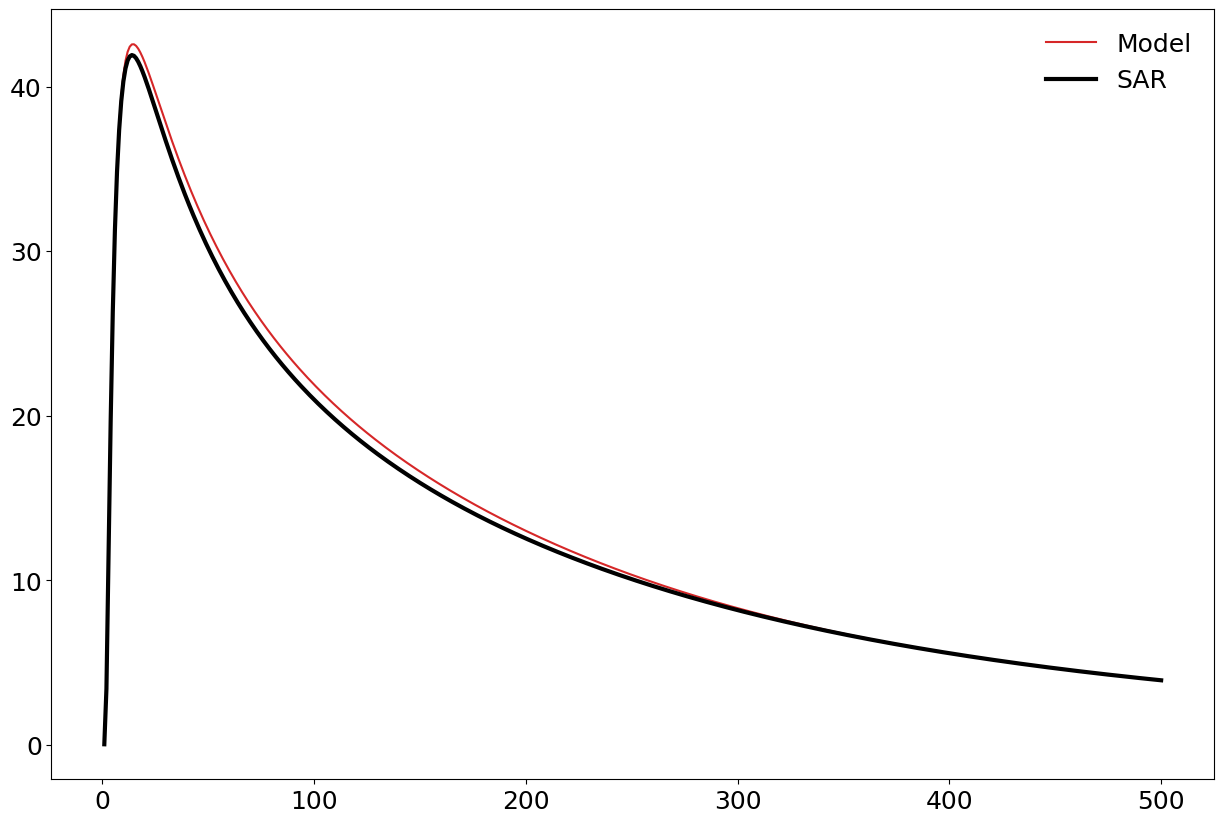

In [139]:
### Asymmetries and wind profile
# Compute asymmetries on Kepert wind field
aks         = []
pks         = []
# Iterate over all radii
for rad in tqdm(xs): # Iterate only in the valid range to optimize time
    ak, phi, _  = get_wn1(np.deg2rad(kep_pol.sel(z=10).theta), kep_pol.sel(z=10).wind_speed.sel(rad=rad, method='nearest'), np.max(Vs[0, 0, :]) / 3, np.max(Vs[0, 0, :]))
    aks.append(ak)
    pks.append(phi)

# Asymmetry amplitude
plt.plot(xs / 1000, aks, c='tab:red', label='Model')
plt.plot(xs / 1000, ACN, c='k', linewidth=3, label='SAR')
plt.axvline(rmx / 1000,        c='k')
plt.axvline(ds.rps / 1000,     c='gray')
plt.axvline(2 * rmx / 1000,    c='tab:blue', alpha=0.3)
plt.legend(frameon=False)
plt.show()

# Asymmetry phase
plt.plot(xs / 1000,  np.rad2deg(pks), c='tab:red', label='Model')
plt.plot(xs / 1000, np.rad2deg(PHS), c='k', linewidth=3, label='SAR')
plt.axvline(rmx / 1000,        c='k')
plt.axvline(ds.rps / 1000,     c='gray')
plt.axvline(2 * rmx / 1000,    c='tab:blue', alpha=0.3)
plt.legend(frameon=False)
plt.show()

# Wind profile
plt.plot(rs / 1000,  kep_pol.sel(z=10).wind_speed.mean(dim='theta'), c='tab:red', label='Model')
plt.plot(rs / 1000, Vs[0, 0, :], c='k', linewidth=3, label='SAR')
plt.legend(frameon=False)

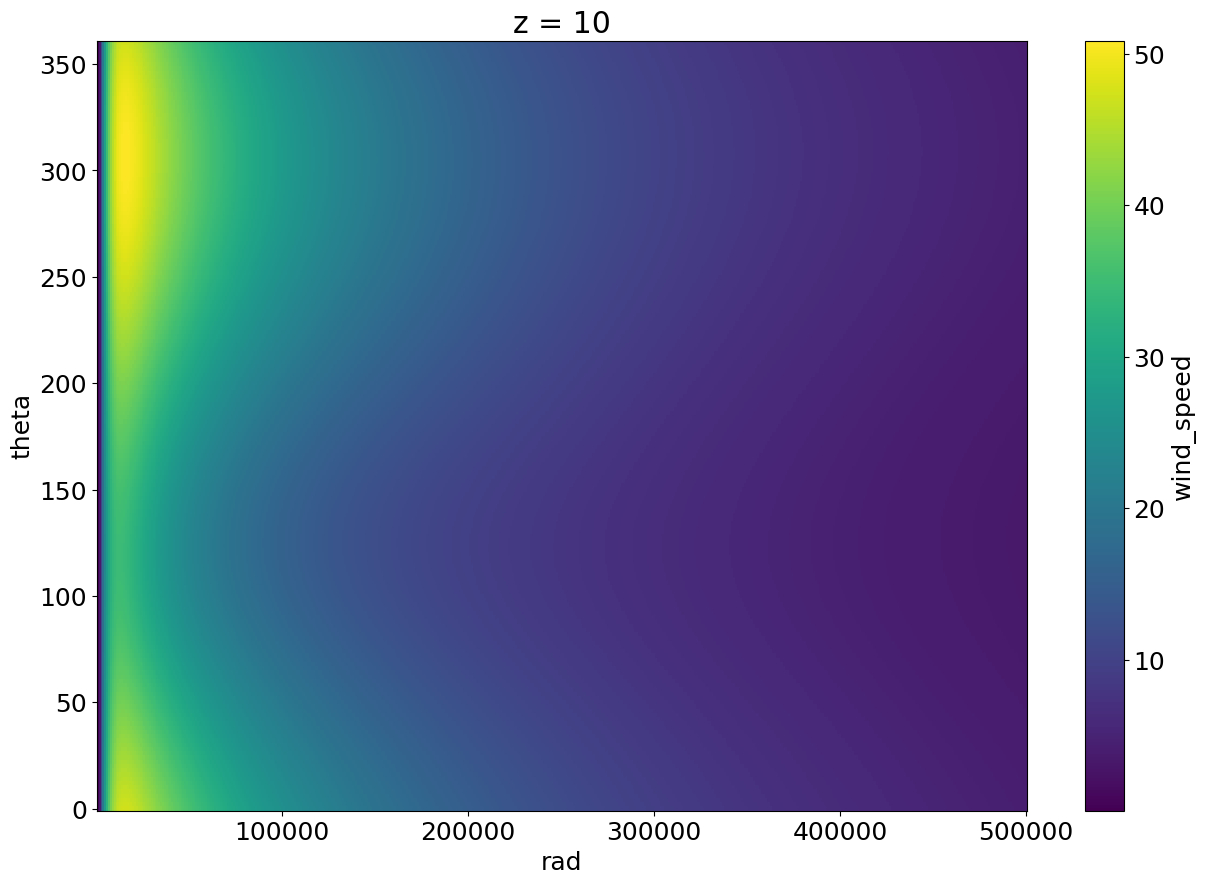

In [140]:
kep_pol.sel(z=10).wind_speed.plot()

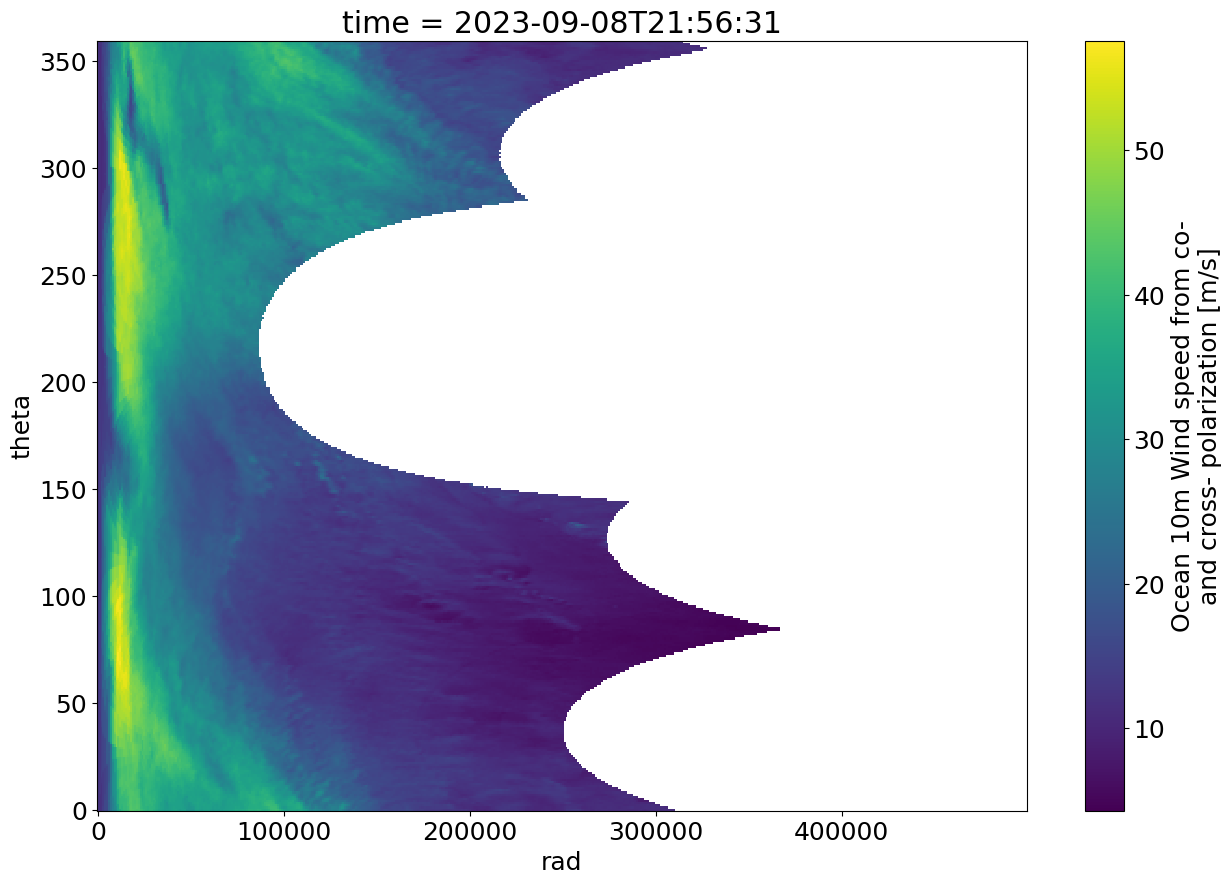

In [141]:
dsp.wind_speed.transpose().plot()

#### Manual RMSE

In [111]:
# kep_pol = get_kepert_polar_at_surface(THs, Rs, ths, rs, Vs, K, C, c1, c2, fcr, z_ref, h)
# float(rmse(kep_pol.interp(coords={'rad': np.array(dsp.wind_speed.transpose().rad)}).sel(theta=slice(0, 359)).wind_speed, dsp.wind_speed.transpose()))

In [110]:
# Ks  = [1, 50, 100, 150, 200]
# c1s = [-2, -1, -0.5, 0., 1, 2.]
# # c2s = [-2, -1, -0.5, 0., 1, 2.]
# c2s = np.linspace(-10, 10, 11)

In [109]:
Ks  = [1, 50, 100, 150, 200]
c1s = [-2, -1, -0.5, 0., 1, 2.]
c2s = [-2, -1, -0.5, 0., 1, 2.]

In [500]:
RMSE = []

for K in tqdm(Ks):
    for c1 in c1s:
        for c2 in c2s:
            kep_pol = get_kepert_polar_at_surface(THs, Rs, ths, rs, Vs, K, C, c1, c2, fcr, z_ref, h)
            RMSE.append(float(rmse(kep_pol.interp(coords={'rad': np.array(dsp.wind_speed.transpose().rad)}).sel(theta=slice(0, 359)).wind_speed, dsp.wind_speed.transpose())))

  0%|          | 0/5 [00:00<?, ?it/s]

In [516]:
dar = xr.DataArray(
    np.array(RMSE).reshape((len(Ks), len(c1s), len(c2s))),
    coords={'K': Ks, 'c1': c1s, 'c2': c2s},
    dims=["K", "c1", "c2"],
)

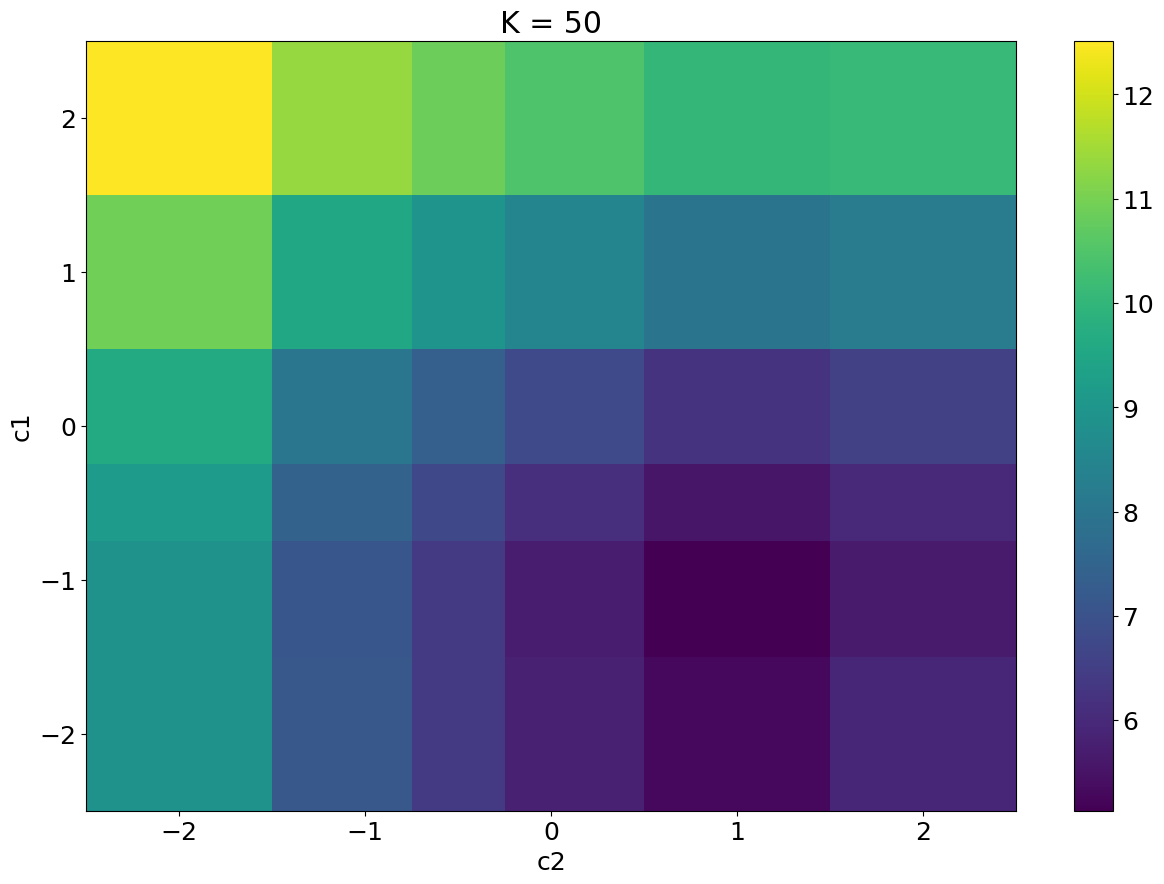

In [519]:
# dar.isel(K=1).plot()

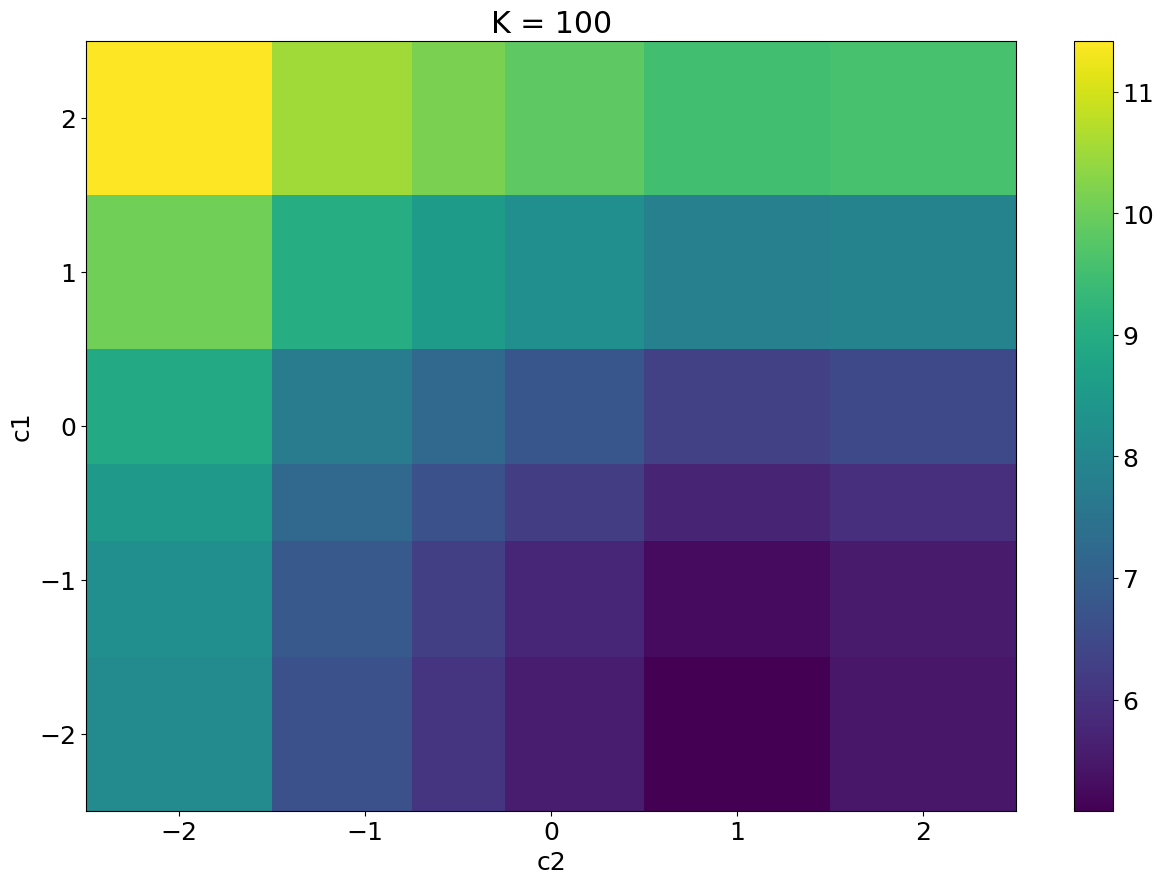

In [520]:
# dar.isel(K=2).plot()

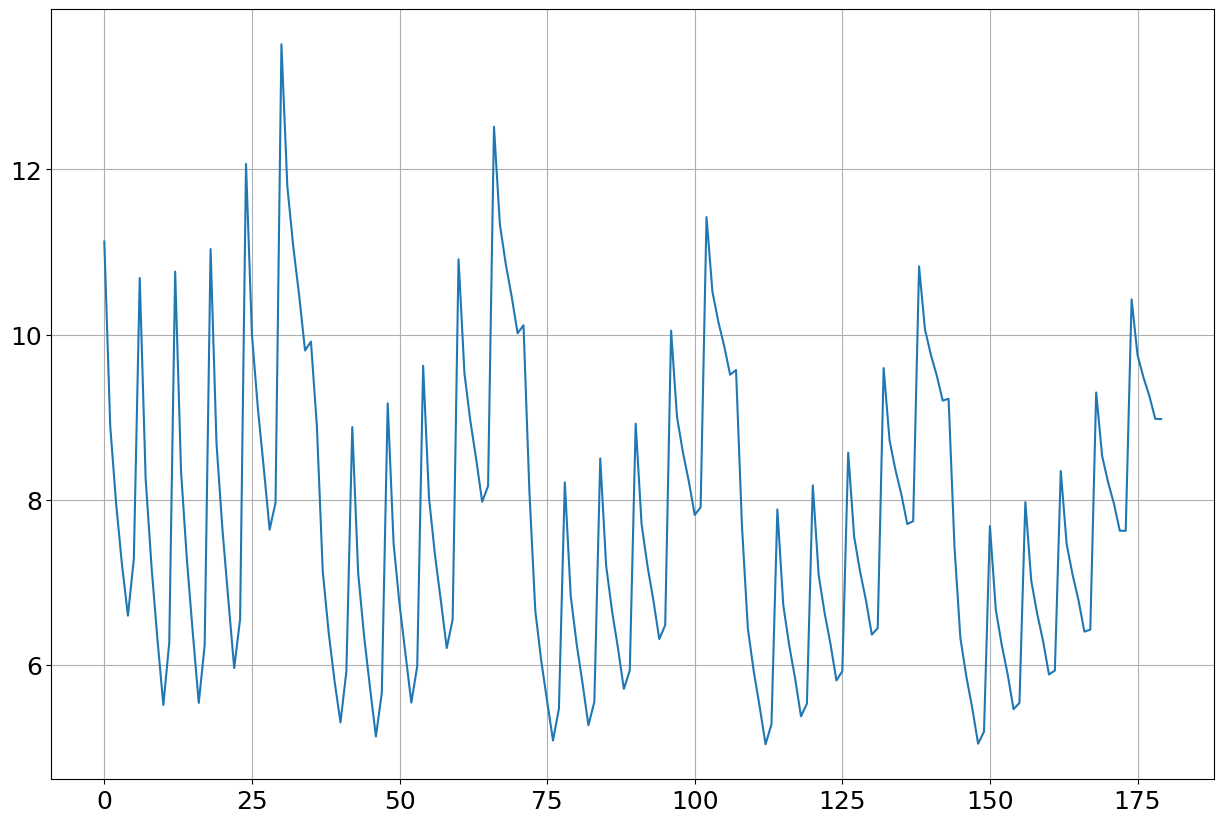

In [506]:
plt.plot(RMSE)
plt.grid()

#### Test with drag coefficient

Avg Cd = 2.15e-3


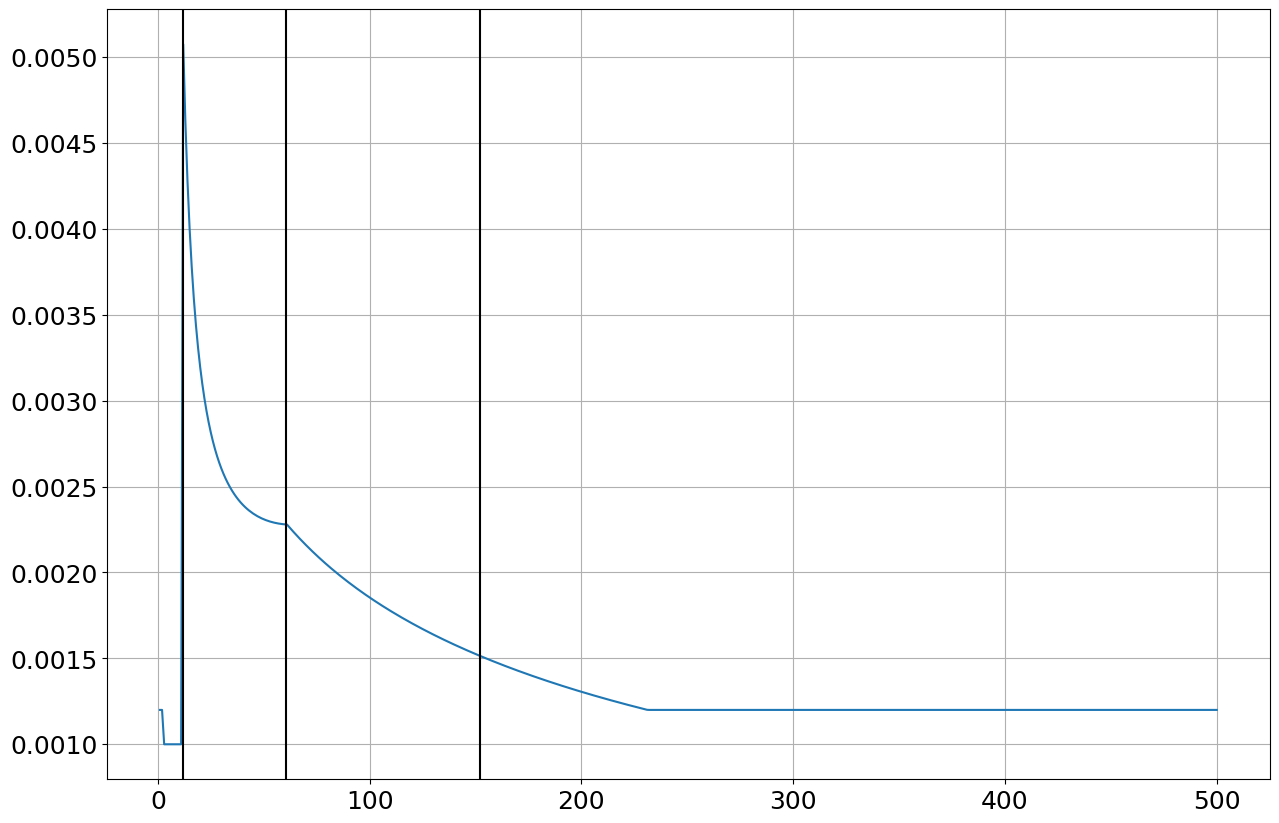

In [99]:
cd             = np.ones_like(V) * 1e-3

# For r > R+
cd[V <= 10.92] = 1.2e-3 # We use 10.92 instead of 11 to ensure continuity of Cd
outer          = (V > 10.92) & (rs >= float(ds.rps))
cd[outer]      = (0.49 + 0.065 * V[outer]) * 1e-3
# For Rmax < r < R+
cdps           = cd[rs >= float(ds.rps)][0]
near           = (rs <= float(ds.rps)) & (rs >= float(ds.rmx))
cd[near]       = cdps * rs[rs >= float(ds.rps)][0] * V[rs >= float(ds.rps)][0] ** 2 / (rs[near] * V[near] ** 2)
# cd[near]       = cdps * float(ds.rps) * float(ds.vps) ** 2 / (rs[near] * V[near] ** 2)

cd_mean = cd[(rs >= float(ds.rmx)) & (rs <= float(ds.r0))].mean()
print('Avg Cd = {:.2f}e-3'.format(cd_mean * 1e3))

plt.plot(rs / 1000, cd)
plt.axvline(ds.rps / 1000, c='k')
plt.axvline(ds.rmx / 1000, c='k')
plt.axvline(ds.r0  / 1000, c='k')
# plt.xlim(200, 250)
# plt.ylim(0.0011, 0.0013)
# plt.xlim(55, 65)
# plt.ylim(0.002, 0.0025)
plt.grid()